In [2]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *

#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots
import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use(['science', 'no-latex'])
%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', 'X', '+', '*']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/local_pert/OBC/


In [3]:
def page(L, f):    
    return f * L * np.log(2) - binom(2 * f * L, f * L) / binom(L, L/2) / 2

def page_result(L_a, L_b):
    d_a = 2**L_a
    d_b = 2**L_b
    return digamma(d_a * d_b + 1) - digamma(d_b + 1) - (d_a - 1) / (2*d_b)
    
def page_result_var(d_a, d_b):
    return (((d_a + d_b)/(d_a*d_b + 1.0)) * polygamma(1, d_b + 1)) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2.0 * d_b - 1.0))/(4.0 * d_b * d_b * (d_a * d_b  + 1.0))

def page_thermodynamic(f, L):
    return f * L * np.log(2.) - np.power(2., -np.abs(1.-2.*f)*L - 1.0)

def page_thermodynamic_var(f, L):
    return (1/2 - 1/4 * (1.0 if f == 1/2 else 0.0)) * np.power(2., -(1+np.abs(1-2*f))*L)

def Srand(L, f): 
    return page(L, f) + (f + np.log(1-f)) / 2. 

In [4]:

L=18
J=2.
J0=0.5
g=0.3
g0=0.3
h=0.6
w=0.1
k=1
p=1
x=1
if h > 0: x=1
dir_pbc = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/"
dir_obc = "../results/XYZ/symmetries/OBC/Entropy/Eigenstate/"
f = 1/2.
use_Sz_sym = False
scan_lab = r"$\Delta_1$" if use_Sz_sym else r"$h^z$" 
suff = "_su" if use_Sz_sym else ""

h_plot = [0.2, 0.8, 1.6, 2.0]
x_range = hfun.regspace(0.1, 2.1, 0.1)
J_range = hfun.regspace(0.1, 2.1, 0.1)

spin_flip_sectors = [-1, 1] if use_Sz_sym else [1]
parity_sectors = [-1, 1]

def get_sectors(L, use_Sz_sym = False):
    translation_real_sectors = [0, L // 2]
    translation_imag_sectors = range(1, L // 2)

    real_sectors = [[ks, ps, xs] for ks in translation_real_sectors for ps in parity_sectors for xs in spin_flip_sectors]
    imag_sectors = [[kx, 1, x_sym] for kx in translation_imag_sectors for x_sym in spin_flip_sectors]
    return real_sectors, imag_sectors

real_sectors, imag_sectors = get_sectors(L)
print(real_sectors, imag_sectors)
all_sectors = real_sectors + imag_sectors

[[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1]] [[1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]


In [5]:

def get_data(L, J, xx, ksym, psym, xsym, use_Sz_sym = False, which = 1, get_states = True, plot_abs = False):
    info = hfun.info_sym(L, J, xx, h, ksym, psym, xsym) if use_Sz_sym else hfun.info_sym(L, J, g, xx, ksym, psym, xsym)
    info = dir_pbc + info[0 : info.index('.dat')]

    filename = info + "_subsize=%d.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            #print(info, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
            dim = energies.size
            V = []
            if len(file.keys()) > 2 and get_states: 
                Vfull = np.array(file.get('eigenvectors')).view('complex')
                szejp = Vfull.shape
                V = Vfull.flatten()
                
                var_theory = 2 * dim if which == 1 else dim
                print(J, xx, "\t", ksym, "\t", psym, "\t", szejp, "\t", 1./var_theory - np.var(Vfull))
                if plot_abs:
                    V *= np.sqrt(var_theory)
                else:
                    V = V.real * np.sqrt(var_theory)
                    if any(V.imag > 1e-10):
                        V = np.concatanate(V, V.imag * np.sqrt(var_theory))

        return True, energies, entropy, np.abs(V)
    else:
        print(filename)
        return False, np.array([]), np.array([]), np.array([])

In [6]:

def get_data_obc(L, J, xx, psym, xsym, use_Sz_sym = False, which = 1, get_states = True):
    info = hfun.info_sym(L, J, xx, h, 0, psym, xsym) if use_Sz_sym else hfun.info_sym(L, J, g, xx, 0, psym, xsym)
    info = dir_obc + info[0 : info.index('.dat')]

    filename = info + "_subsize=%d.hdf5"%(f * L)
    if exists(filename) and abs(int(f * L) - f * L) < 0.01:
        data = []
        with h5py.File(filename, "r") as file:
            # Print all root level object names (aka keys) 
            # these can be group or dataset names 
            #print(info, "Keys: %s" % file.keys())
            energies = np.array(file.get('energies')[0])
            entropy = np.array(file.get('entropy')[0])
            dim = energies.size
            V = []
            if len(file.keys()) > 2 and get_states: 
                Vfull = np.array(file.get('eigenvectors')).view('complex')
                szejp = Vfull.shape
                V = Vfull.flatten()
                
                print(J, xx, "\t", psym, "\t", szejp, "\t", 1./dim - np.var(Vfull))

        return True, energies, entropy, np.abs(V) * np.sqrt(dim)
    else:
        print(filename)
        return False, np.array([]), np.array([]), np.array([])

# PARAMETER SCAN

xx	k	p	shape		var diff
0.1 	 0 	 -1 	 (201, 6918) 	 -6.9124615908360606e-09
0.1 	 0 	 1 	 (201, 7686) 	 3.991224822511149e-09
0.1 	 9 	 -1 	 (201, 7400) 	 -2.371084762152519e-09
0.1 	 9 	 1 	 (201, 7144) 	 -1.0706909304281477e-08
0.2 	 0 	 -1 	 (201, 6918) 	 -1.2267438425652387e-08
0.2 	 0 	 1 	 (201, 7686) 	 -7.57726221250663e-09
0.2 	 9 	 -1 	 (201, 7400) 	 -1.1233862667441854e-08
0.2 	 9 	 1 	 (201, 7144) 	 -7.562626377997234e-09
0.3 	 0 	 -1 	 (201, 6918) 	 -7.020491060700075e-09
0.3 	 0 	 1 	 (201, 7686) 	 -2.1769836841632056e-08
0.3 	 9 	 -1 	 (201, 7400) 	 -1.7764021428178433e-08
0.3 	 9 	 1 	 (201, 7144) 	 1.9042155861837256e-09
0.4 	 0 	 -1 	 (201, 6918) 	 1.7900624475005074e-09
0.4 	 0 	 1 	 (201, 7686) 	 -3.614511073801209e-10
0.4 	 9 	 -1 	 (201, 7400) 	 4.282703980622478e-09
0.4 	 9 	 1 	 (201, 7144) 	 8.023057798878979e-09
0.5 	 0 	 -1 	 (201, 6918) 	 8.164250432499999e-09
0.5 	 0 	 1 	 (201, 7686) 	 2.8392802094352222e-09
0.5 	 9 	 -1 	 (201, 7400) 	 4.178028287487451e-0

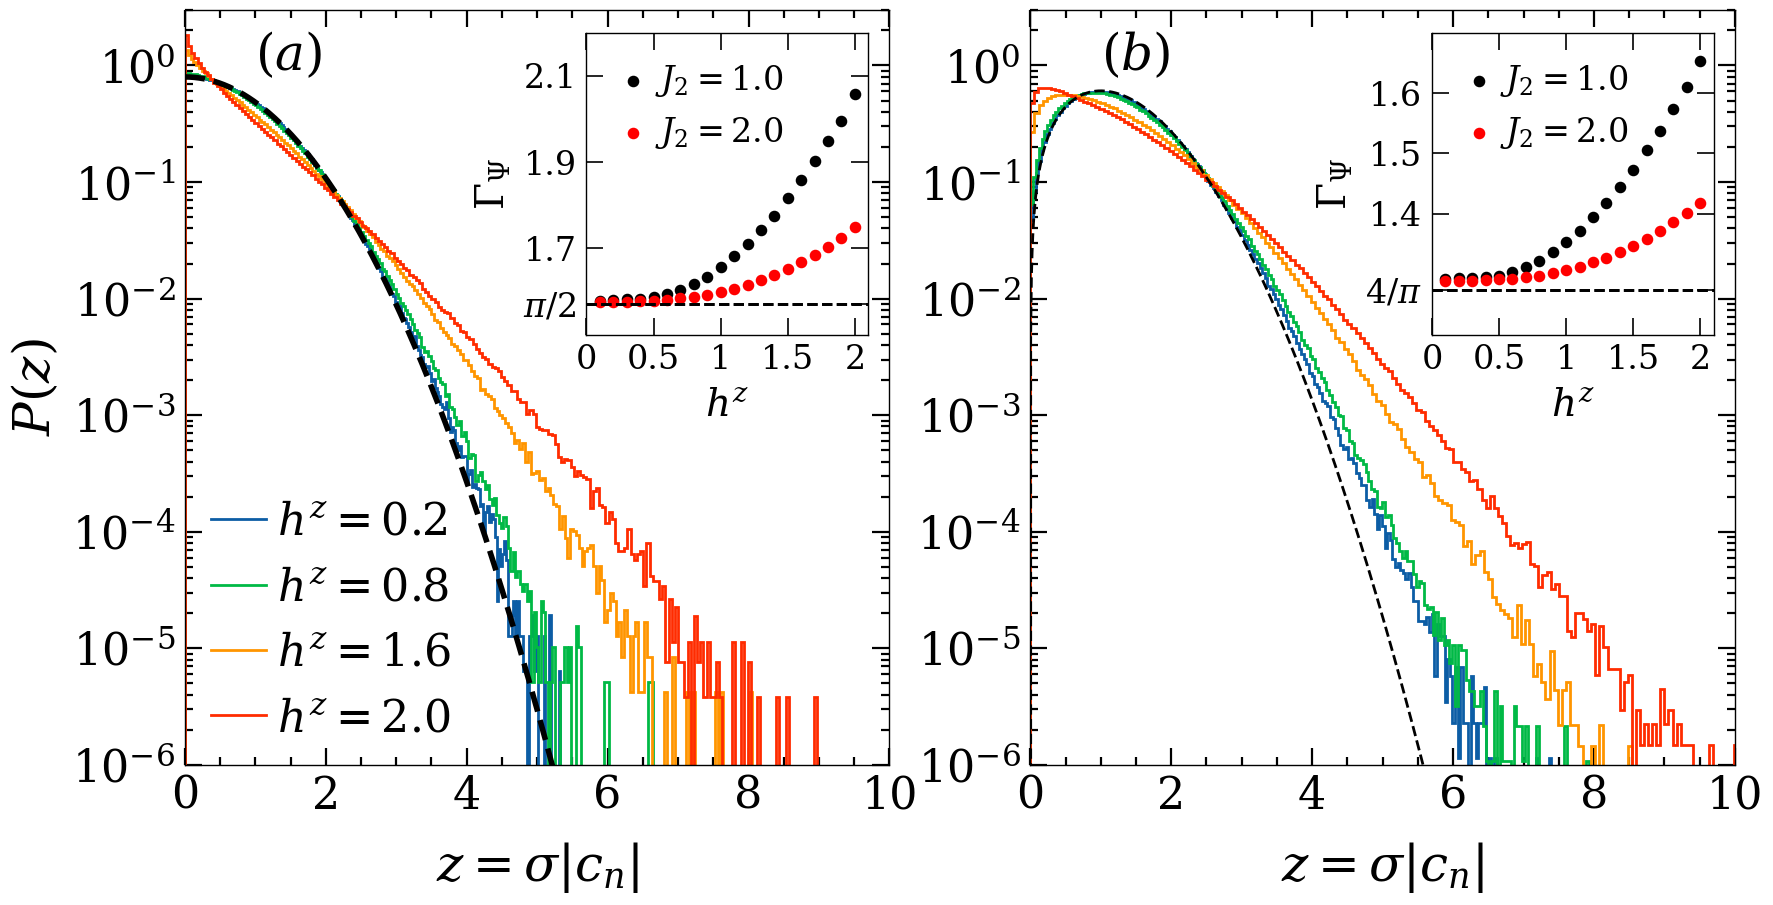

In [7]:
reload_modules()

#real_sectors = [[0, 1, 1]]
#imag_sectors = [[1, 1, 1]]
#fig_dist, ax_dist = plt.subplots( nrows=1, ncols=2, figsize=(12,5), dpi = 200)
fig_dist = plt.figure(figsize=(10,5), dpi = 200)
fig_dist.tight_layout(pad=2.0)

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
ax_dist = [None, None]
ax_dist[0] = fig_dist.add_subplot(gs[0])
ax_dist[1] = fig_dist.add_subplot(gs[1])


plot_abs = True

width = 0.4
height = 0.4
ax_inset = [None, None]
for i, ax in enumerate(ax_dist):    
    #ax_inset[i] = hfun.add_subplot_axes(ax, [0.18 + 0.05 * i, 0.12, width, height])
    ax_inset[i] = hfun.add_subplot_axes(ax, [0.97 - width, 0.97 - height, width, height])

print("xx\tk\tp\tshape\t\tvar diff")

points = [[1.0, haha] for haha in x_range] + [[2.0, haha] for haha in x_range]
colors = ['red', 'black']
def plotter(which):
    ax_all = [ax_inset[which], ax_dist[which]]
    sectors = real_sectors if which == 0 else imag_sectors
    gap_ratio = []
    gauss = []
    for [J, xx] in points:
        wx = xx/2
        Smean_ener = []
        Smax = []
        validL = []
        coeffs = []
        for [ks, ps, xs] in sectors:
            status, energies, entropy, V = get_data(which=which, L=L, J=J, xx=xx, ksym = ks, psym = ps, xsym=xs, plot_abs=plot_abs)
            if status:
                factor = which + 1
                coeffs += factor * list(V)
        
        coeffs = np.array(coeffs)
        if xx in h_plot and J == 1.0:
            hist, edge = np.histogram(coeffs, bins=200, normed=True)
            #ax_dist[which].plot(edge[:-1], hist, marker='o', markersize=1, linewidth=0.5, label=r"$h^z=%.1f$"%(xx))
            ax_dist[which].stairs(hist, edge, label=scan_lab + r"$=%.1f$"%(xx))

        coeffs = np.abs(coeffs)
        gaussianity = np.mean(np.square(coeffs)) / np.mean(coeffs)**2
        if xx == points[1][0]:
            ax_inset[which].scatter(xx, gaussianity, s=10, label=r"$J_2=%.1f$"%(J), color='black' if J == 1.0 else 'red')
        else:
            ax_inset[which].scatter(xx, gaussianity, s=10, color='black' if J == 1.0 else 'red')


    ylab = "P(z)" if which == 0 else "\ "
    xlab = "z=\\sigma|c_n|"
    hfun.set_plot_elements(axis = ax_dist[which], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    if which == 0:
        #ax_dist[which].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))
        ax_dist[which].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




    val = np.pi / 2 if which == 0 or not plot_abs else 4. / np.pi
    valname = r"$\pi/2$" if which == 0 or not plot_abs else r"$4/\pi$"
    
    ax_inset[which].axhline(y=val, ls='--', color='black')

    hfun.set_plot_elements(axis = ax_inset[which], ylabel = "\\Gamma_\\Psi", xlabel = "\\Delta_1" if use_Sz_sym else "h^z", settings=user_settings, 
                            font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax_inset[which].legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)
    ax_inset[which].set_xlim(0, 2.1)
    
    for ax in list(ax_all):
        ax.set_xscale('linear')    
        ax.set_yscale('linear')
        ax.tick_params(axis="both",which='major',direction="in",length=6)
        ax.tick_params(axis="both",which='minor',direction="in",length=3)

    ax_inset[which].axhline(y=val, ls='--', color='black')
    yticks = [val, 1.7, 1.9, 2.1] if which == 0 or not plot_abs else [val, 1.4, 1.5, 1.6]   
    tick_labels = ["%.1f"%ytic if ytic != val else valname for ytic in yticks]
    ax_inset[which].set_yticks(yticks)
    ax_inset[which].set_yticklabels(tick_labels)
    if plot_abs:
        ax_inset[0].set_ylim(1.5, 2.2)
        ax_inset[1].set_ylim(1.2, 1.7)
    else:
        ax_inset[which].set_ylim(1.5, 2.2)
#
    xticks = [0, 0.5, 1.0, 1.5, 2.0]
    tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
    ax_inset[which].set_xticks(xticks)
    ax_inset[which].set_xticklabels(tick_labels)
#
    ax_inset[which].xaxis.set_minor_locator(plt.NullLocator())
    ax_inset[which].yaxis.set_minor_locator(plt.NullLocator())


    ax_dist[which].set_xscale('linear')
    ax_dist[which].set_yscale('log')
    aa = np.linspace(-100.0, 100, 20000)
    mu=0.0
    sigma=1.
    ax_dist[which].set_ylim(1e-6, 3.0)
    ax_dist[which].set_xlim(0, 10)

    if which == 0 or not plot_abs:    
        ax_dist[which].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    else:             
        ax_dist[which].plot(aa, aa * np.exp( - aa**2 / (2)), linestyle='--', color='black')


plotter(0)
plotter(1)
ax_dist[0].annotate(r"$(a)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')
ax_dist[1].annotate(r"$(b)$", xy=(0.1, 0.92), fontsize=18, xycoords='axes fraction')

real_sectors, imag_sectors = get_sectors(L)
suff = "_abs" if plot_abs else ""
plt.savefig(f'Fig_coeff{suff}.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'Fig_coeff{suff}.png', bbox_inches = 'tight', padding=0.02)

## REAL SECTORS

### LOAD

In [39]:
reload_modules()

def load_real(use_Sz_sym):
    if use_Sz_sym:
        J0=0.0
        g0=0.0
        h=0.0
        
    level_spacings = []
    gap_ratio = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    gaussianity = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_max = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    info_ent = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)

    for ii, xx in enumerate(x_range[:-1]):
        edges_tmp = []
        gaps_distribution = []
        spacings = []
        for jj, Jx in enumerate(J_range[:-1]):

            def get_data(ksym, psym, xsym = 1):
                info = hfun.info_sym(L, Jx, g, xx, ksym, psym, xsym)
                info = dir + info[0 : info.index('.dat') :]

                filename = info + "_subsize=%d.hdf5"%(f * L)
                if exists(filename):  
                    data = []
                    with h5py.File(filename, "r") as file:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names 
                        #print(info, "Keys: %s" % file.keys())
                        energies = np.array(file.get('energies')[0])
                        entropy = np.array(file.get('entropy')[0])
                        dim = energies.size

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        information_ent = 0
                        if len(file.keys()) > 2: 
                            Vfull = np.array(file.get('eigenvectors')).view('complex')
                            print(Jx, xx, ksym, psym, Vfull.shape)
                            V = np.array(Vfull.flatten())
                            skwer = np.square(np.abs(V))
                            information_ent = - np.sum(skwer * np.log(skwer)) / (201. * np.log(0.48 * dim) )

                            V = np.abs(V) * np.sqrt(dim)
                    return True, energies, entropy, V, information_ent
                else:
                    print(filename)
                    return False, np.array([]), np.array([]), np.array([]), np.nan

            coeffs = []
            S = 0
            Smax_tmp = 0
            r = 0
            Sinf = 0
            cunt = 0
            dims_tot = 0
            gaps_dist_tmp = []
            gaps_all = []
            for [kk, px] in real_sectors:
                status, energies, entropy, V, Sinf_tmp = get_data(ksym = kk, psym = px)
                if status:
                    coeffs += list(V)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    size = energies.size
                    
                    num = 500 if L > 8 else 100
                    #num = 0.5 * size
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0

                    my_max = int(index_meanE + num / 2) 
                    if my_max>= size: my_max = size

                    if max(entropy) > Smax_tmp: Smax_tmp = max(entropy)
                    sample = entropy[my_min : my_max]

                    dims_tot += energies.size
                    S += energies.size * np.mean(sample)
                    #S += np.mean(sample)
                    Sinf += Sinf_tmp

                    gaps = np.diff(energies)
                    gaps_all += list(gaps)

                    r_tmp = 0
                    counter = 0
                    for i in range(int(int(index_meanE - 0.5 * size / 2)), int(int(index_meanE + 0.5 * size / 2))):
                        r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                        counter += 1
                    r += r_tmp / counter
                    cunt += 1
                #else: print("Not Found :( ")

            coeffs = np.abs(np.array(coeffs))

            gaussianity[ii, jj] = np.mean(np.square(coeffs)) / np.mean(coeffs)**2 - np.pi / 2 if cunt > 0 else np.nan
            gap_ratio[ii, jj] = r / cunt if cunt > 0 else np.nan
            ent_max[ii, jj] = page(L, f) -  Smax_tmp if cunt > 0 else np.nan
            ent[ii, jj] = page(L, f) -  S / dims_tot if cunt > 0 else np.nan
            info_ent[ii, jj] = Sinf / cunt if cunt > 0 else np.nan
            
            spacings.append(gaps_all)
            
        level_spacings.append(np.array(spacings))

    return np.array(level_spacings), np.array(gaussianity), np.array(gap_ratio), np.array(info_ent), np.array(ent_max), np.array(ent)


In [40]:

level_spacings, gaussianity, gap_ratio, info_ent, ent_max, ent = load_real(use_Sz_sym=False)

with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_re{suff}.npy', 'wb') as file:      np.save(file, level_spacings)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_re{suff}.npy', 'wb') as file:         np.save(file, gaussianity)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_re{suff}.npy', 'wb') as file:           np.save(file, gap_ratio)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_re{suff}.npy', 'wb') as file:            np.save(file, info_ent)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_re{suff}.npy', 'wb') as file:             np.save(file, ent_max)
with open(f'MAXIMAL_ENTROPY_DATA/ent_re{suff}.npy', 'wb') as file:                 np.save(file, ent)

0.1 0.1 0 -1 (201, 6918)
0.1 0.1 0 1 (201, 7686)
0.1 0.1 9 -1 (201, 7400)
0.1 0.1 9 1 (201, 7144)
0.2 0.1 0 -1 (201, 6918)
0.2 0.1 0 1 (201, 7686)


KeyboardInterrupt: 

In [192]:
with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_re{suff}.npy', 'rb') as file:      level_spacings = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_re{suff}.npy', 'rb') as file:         gaussianity = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_re{suff}.npy', 'rb') as file:           gap_ratio = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_re{suff}.npy', 'rb') as file:            info_ent = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_re{suff}.npy', 'rb') as file:             ent_max = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_re{suff}.npy', 'rb') as file:                 ent = np.load(file)

### PLOT

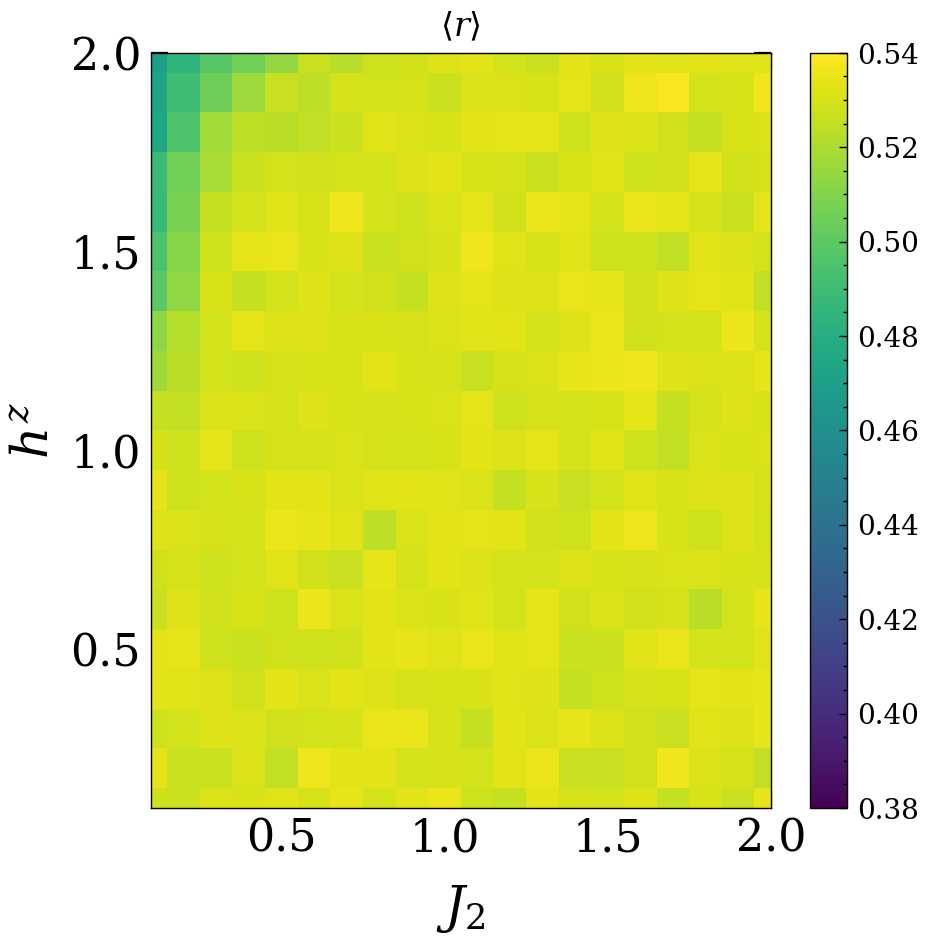

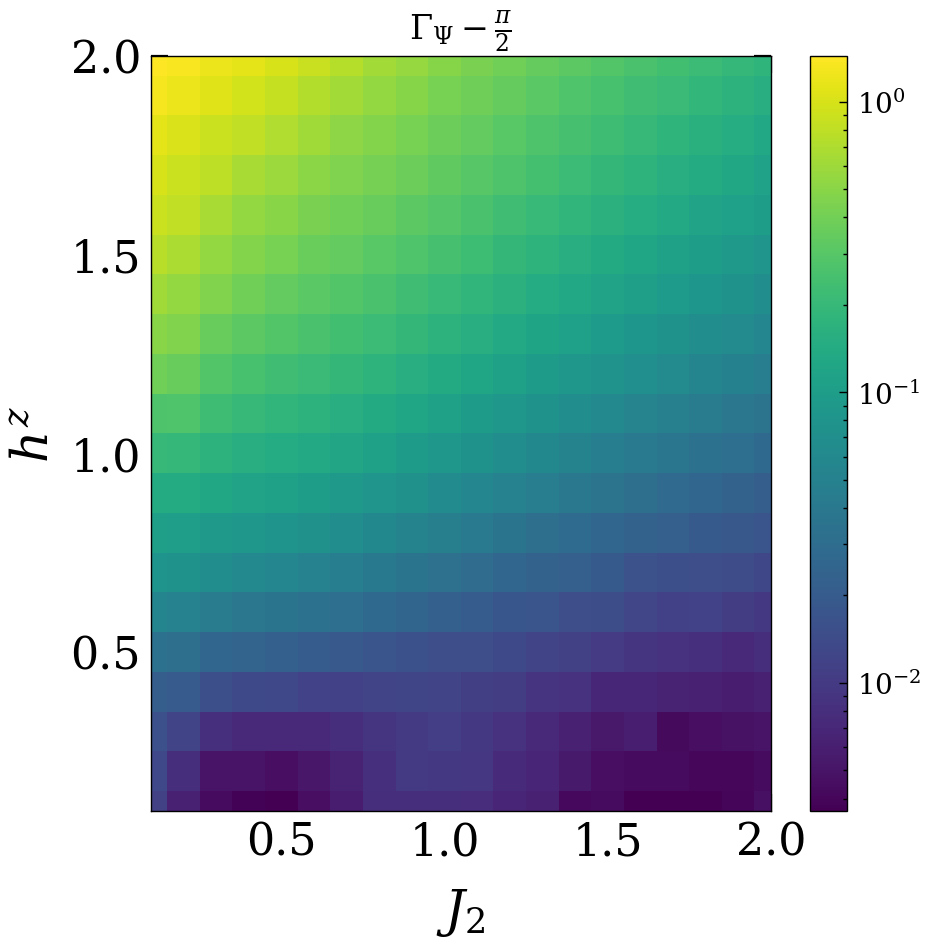

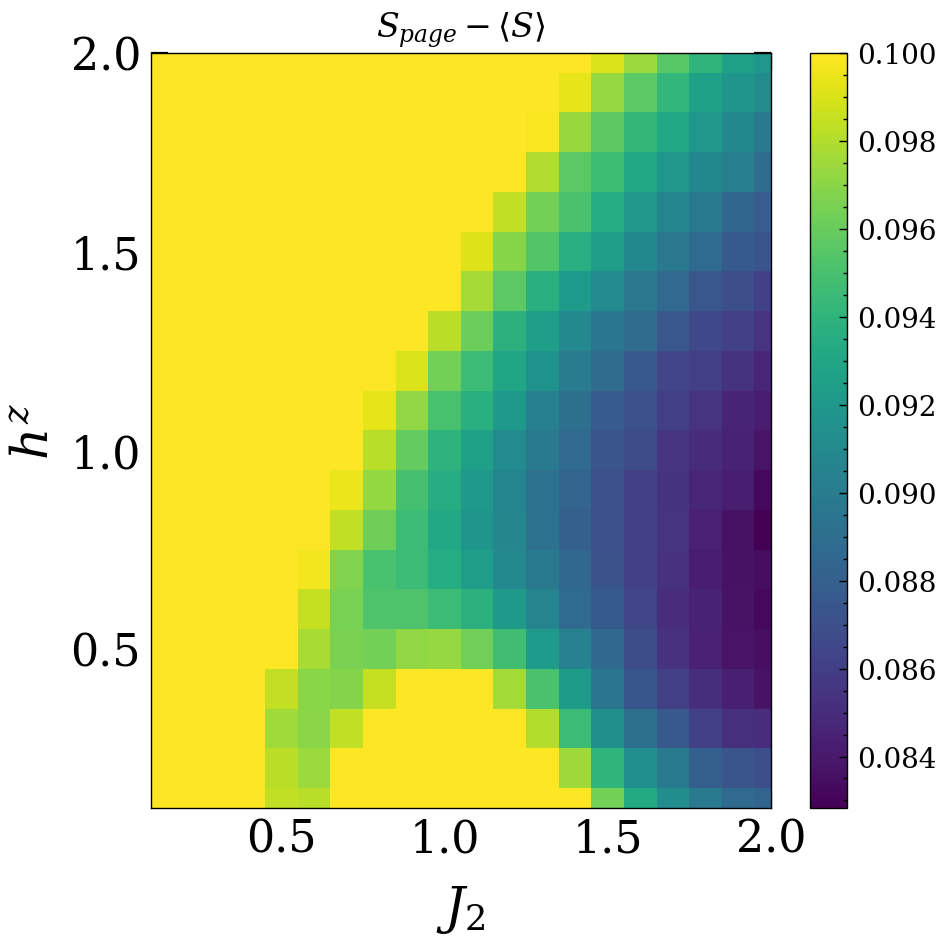

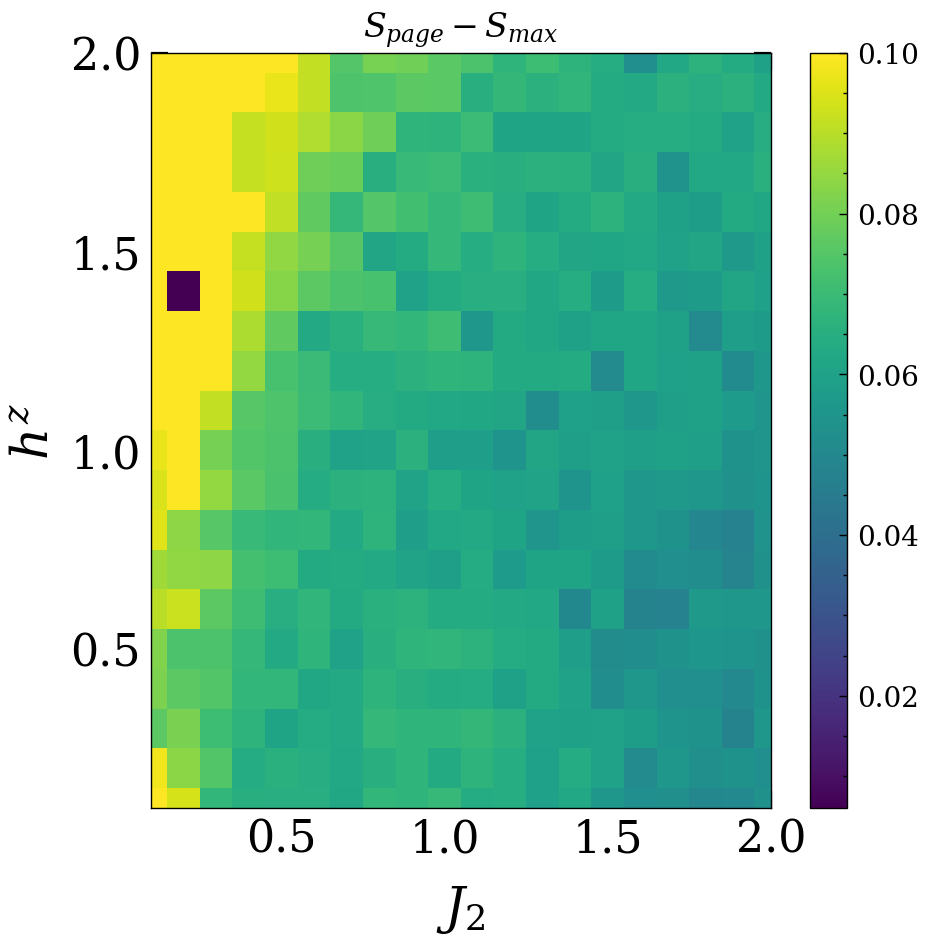

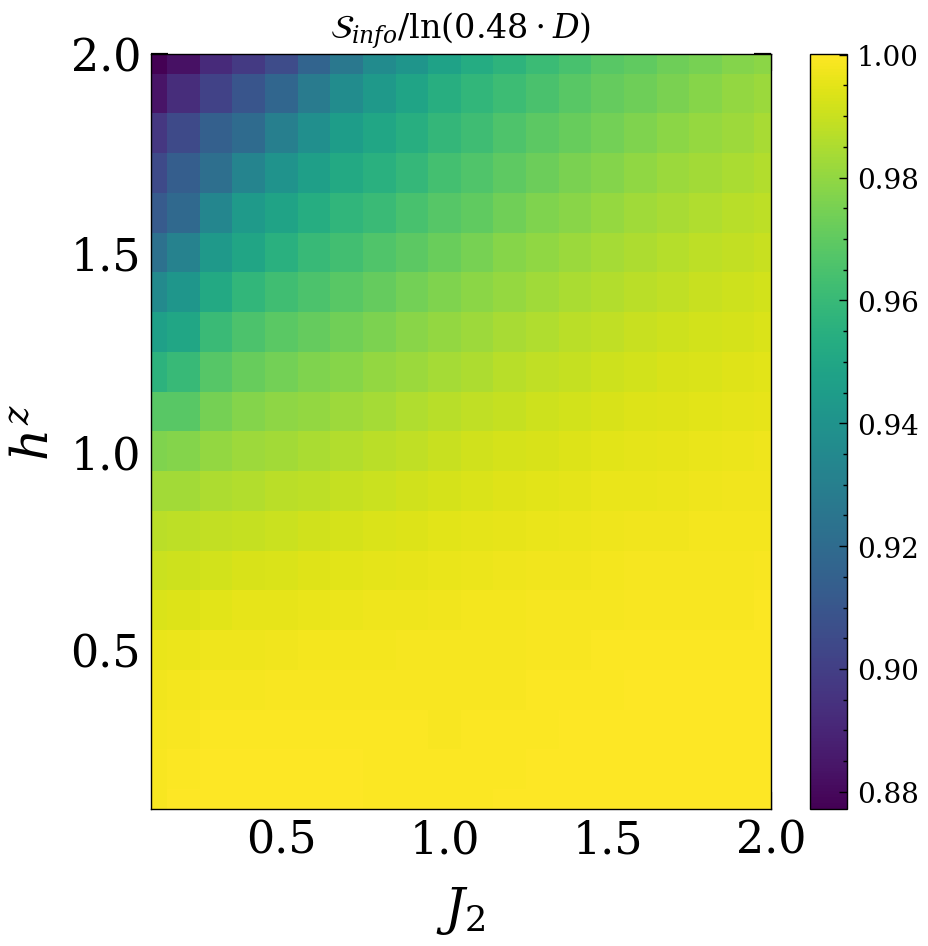

In [193]:

skipX = int(J_range.size / 6)
skipY = int(x_range.size / 6)

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gaps.pcolormesh(X, Y, gap_ratio, shading='nearest', vmin=0.38, vmax=0.54)
ax_gaps.set_title(r"$\langle r\rangle$")
fig.colorbar(p)

fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gauss.pcolormesh(X, Y, gaussianity, shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi - \frac{\pi}{2}$")
fig.colorbar(p)

fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_ent.pcolormesh(X, Y, ent, shading='nearest', vmax=0.1)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$")
fig.colorbar(p)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_outlier.pcolormesh(X, Y, ent_max, shading='nearest', vmax=0.1)
ax_outlier.set_title(r"$S_{page} - S_{max}$")
fig.colorbar(p)

fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_info.pcolormesh(X, Y, info_ent, shading='nearest')
ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
fig.colorbar(p)

for ax in [ax_info, ax_ent, ax_outlier, ax_gaps, ax_gauss]:

    hfun.set_plot_elements(axis = ax, ylabel = "\\Delta_1" if use_Sz_sym else "h^z", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))

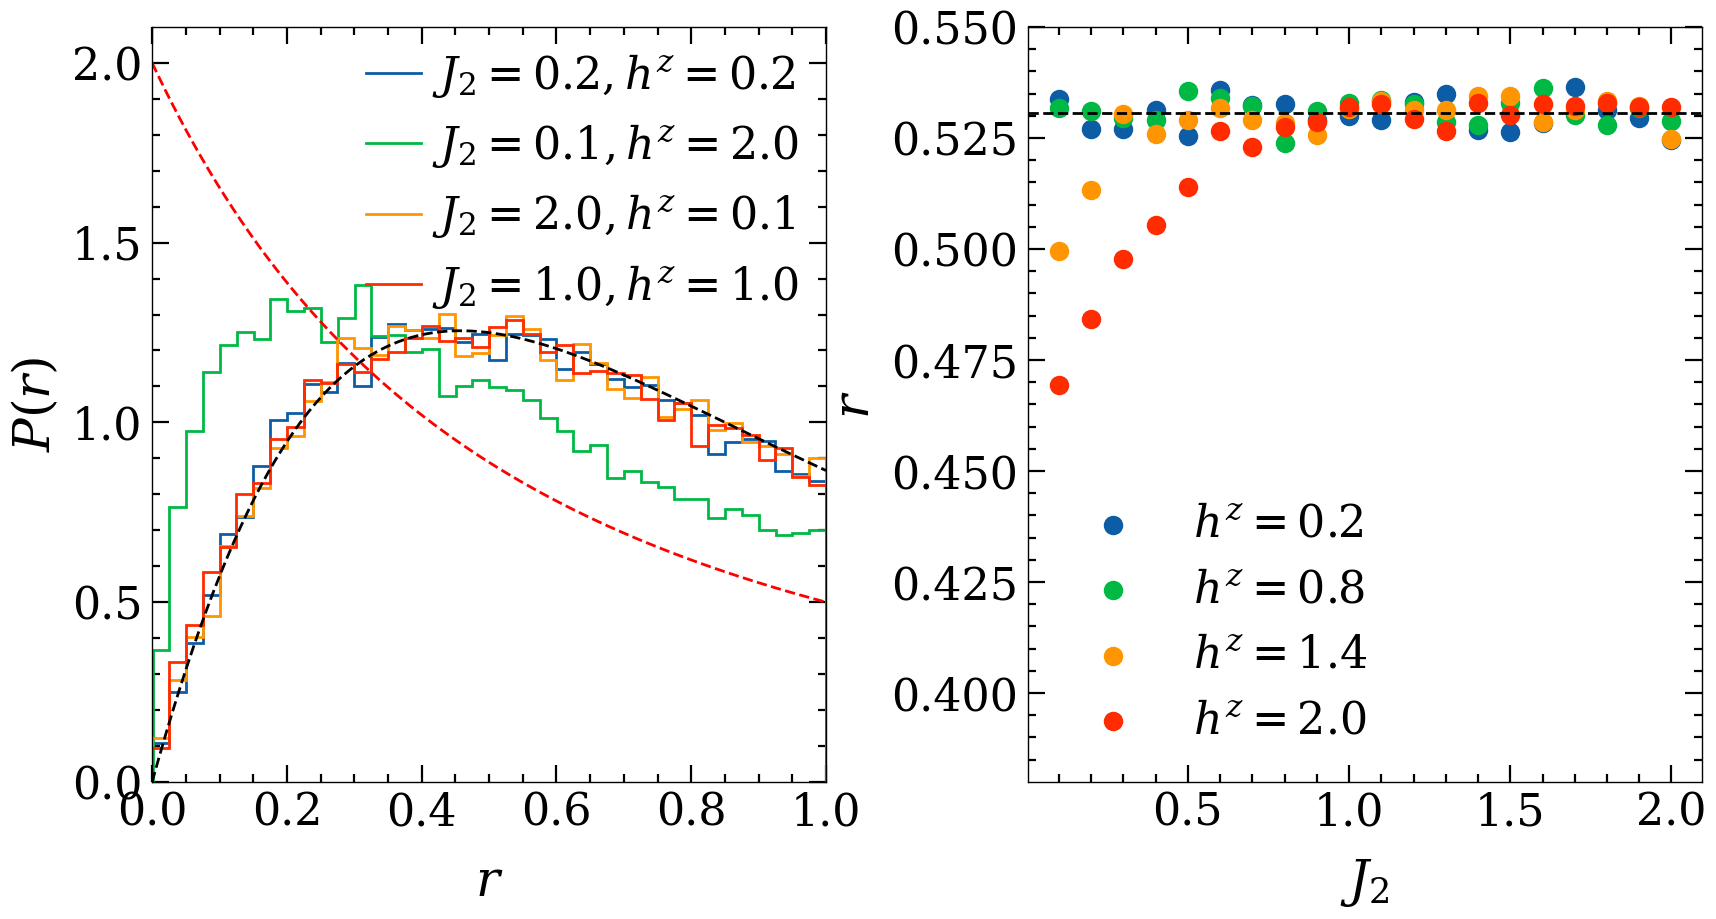

In [ ]:
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)


## --- LEFT PANEL
USE_GAP_RATIO = 1
points_to_plot = [[0.2, 0.2], [0.1, 2.0], [2.0, 0.1], [1.0, 1.0]]
xpoi = np.linspace(0, 1, 100)
if USE_GAP_RATIO:
    axis[0].plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black')
    axis[0].plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red')
else:
    axis[0].plot(xpoi, np.pi / 2 * xpoi * np.exp(-np.pi/4 * xpoi**2), linestyle='--', color='black')
    axis[0].plot(xpoi, np.exp(-xpoi), linestyle='--', color='red')

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(level_spacings[ii][jj])
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
    data = level_stats if USE_GAP_RATIO else gaps
    hist, bins = np.histogram(data, bins=40, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f$"%J2 + scan_lab + r"$=%.1f$"%(xx))
axis[0].set_xlim(0,1)    

## --- RIGHT PANEL

J_to_plot = [0.2, 0.8, 1.4, 2.0]
for J2 in J_to_plot:
    ii = list(J_range).index(J2)
    r = gap_ratio[ii]
    axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2))

axis[1].set_ylim(0.38, 0.55)
axis[1].axhline(y=0.5307, ls='--', color='black')


## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))


hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=True, xlim=(None, None), ylim=(None, None))
for ax in list(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)

fig.subplots_adjust(wspace=0.3, hspace=0.3)


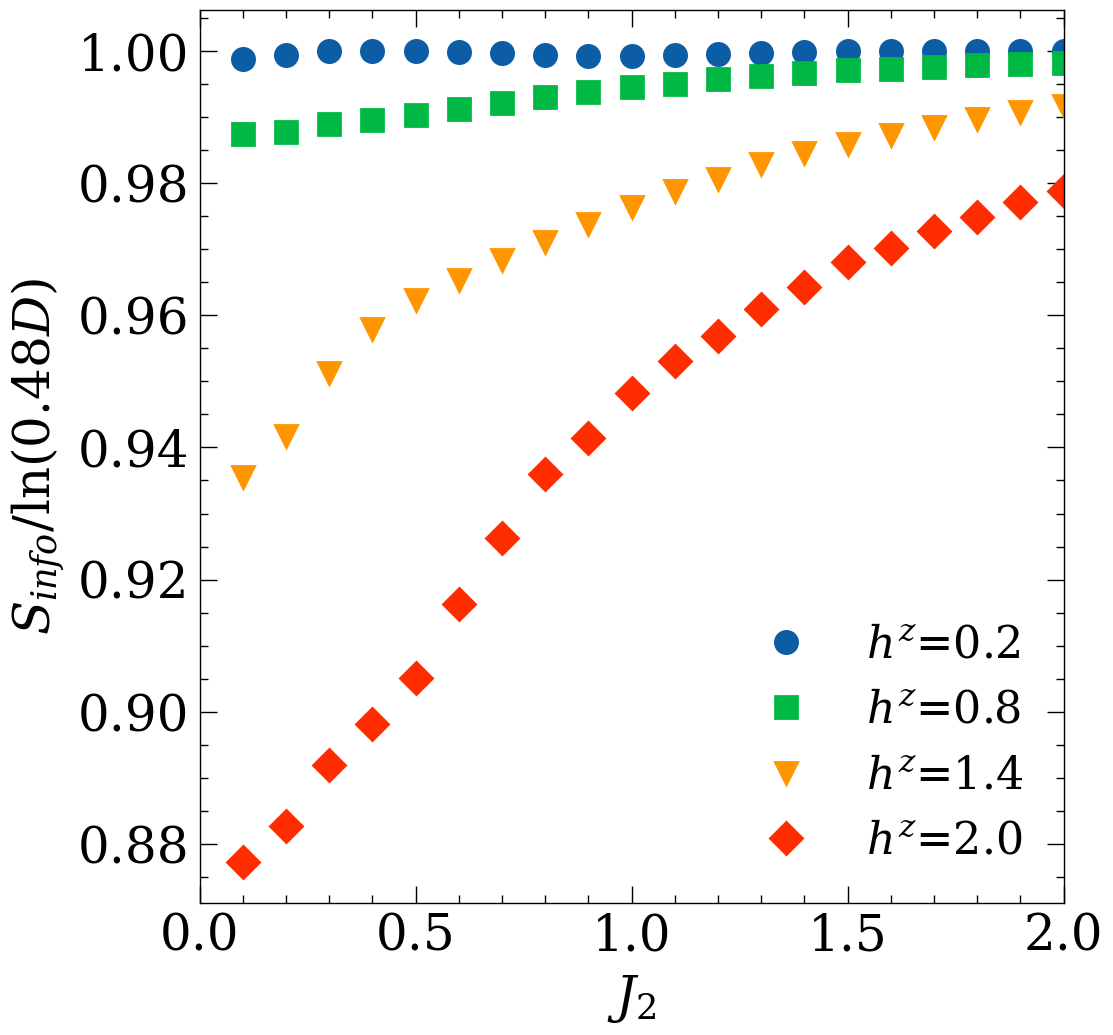

In [35]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.

# plot
fig, ax = plt.subplots(1, figsize = (5, 5), dpi=200)
fig.tight_layout()

h_to_plot = [0.2, 0.8, 1.4, 2.0]
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    ax.plot(J_range, info_ent[ii], label = scan_lab + f'=${xx}$', linewidth=0, marker = next(markers), markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
ax.set_xlabel(label_a, size = 18)
ax.set_ylabel('$S_{info} / \ln(0.48D)$', size = 18)
ax.set_xlim(0.0,2.0)
#ax.set_ylim(1.015, 1.030)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)

ax.tick_params(axis="both",which='major',direction="in", length=6)
ax.tick_params(axis="both",which='minor',direction="in", length=3)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
ax.legend(fontsize = 16)

## IMAGINARY SECTORS

### LOAD

In [30]:
reload_modules()

def load_imag(use_Sz_sym = False):

    if use_Sz_sym:
        J0=0.0
        g0=0.0
        h=0.0

    level_spacings_im = []
    gap_ratio_im   = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    gaussianity_im = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_im         = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    ent_max_im     = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)
    info_ent_im    = np.zeros((len(x_range) - 1, len(J_range) - 1), dtype=np.float)

    for ii, xx in enumerate(x_range[:-1]):
        spacings = []
        for jj, Jx in enumerate(J_range[:-1]):

            def get_data(ksym, psym, xsym = 1):
                info = hfun.info_sym(L, Jx, g, xx, ksym, psym, xsym)
                info = dir + info[0 : info.index('.dat') :]

                filename = info + "_subsize=%d.hdf5"%(f * L)
                if exists(filename):  
                    data = []
                    with h5py.File(filename, "r") as file:
                        # Print all root level object names (aka keys) 
                        # these can be group or dataset names 
                        #print(info, "Keys: %s" % file.keys())
                        energies = np.array(file.get('energies')[0])
                        entropy = np.array(file.get('entropy')[0])
                        dim = energies.size

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        information_ent = 0
                        if len(file.keys()) > 2: 
                            V = np.array(file.get('eigenvectors')).view('complex')
                            print(Jx, xx, ksym, psym, V.shape)

                            V = np.abs(np.array(V.flatten()))
                            skwer = V**2
                            information_ent = - np.sum(skwer * np.log(skwer)) / (201. * np.log(0.48 * dim) )

                            V = V * np.sqrt(2* dim)
                    return True, energies, entropy, V, information_ent
                else:
                    print(filename)
                    return False, np.array([]), np.array([]), np.array([]), np.nan

            coeffs = []
            S = 0
            Smax_tmp = 0
            r = 0
            Sinf = 0
            cunt = 0
            dims_tot = 0
            gaps_all = []
            for [kk, px] in imag_sectors:
                status, energies, entropy, V, Sinf_tmp = get_data(ksym = kk, psym = px)
                if status:
                    coeffs += 2 * list(V)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    dim = energies.size
                    
                    num = 500 if dim > 1000 else 200
                    my_min = int(index_meanE - num / 2)
                    my_max = int(index_meanE + num / 2) 
                    if my_min < 0: my_min = 0
                    if my_max >= dim: my_max = dim
                    
                    if max(entropy) > Smax_tmp: Smax_tmp = max(entropy)
                    sample = entropy[my_min : my_max]

                    gaps = np.diff(energies)

                    r_tmp = 0
                    counter = 0
                    for i in range(int(int(index_meanE - 0.5 * dim / 2)), int(int(index_meanE + 0.5 * dim / 2))):
                        r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                        counter += 1

                    dims_tot += 2 * dim
                    S += 2 * dim * np.mean(sample)
                    Sinf += 2 * Sinf_tmp
                    r += 2 * r_tmp / counter
                    gaps_all += 2 * list(gaps)
                    
                    cunt += 2

            coeffs = np.abs(np.array(coeffs))

            val = 4 / np.pi
            gaussianity_im[ii, jj]  = np.mean(np.square(coeffs)) / np.mean(coeffs)**2 - val if cunt > 0 else np.nan
            gap_ratio_im[ii, jj]    = r / cunt if cunt > 0 else np.nan
            info_ent_im[ii, jj]     = Sinf / cunt if cunt > 0 else np.nan
            
            ent_max_im[ii, jj]      = page(L, f) -  Smax_tmp if cunt > 0 else np.nan
            ent_im[ii, jj]          = page(L, f) -  S / dims_tot if cunt > 0 else np.nan
            
            spacings.append(gaps_all)

        level_spacings_im.append(np.array(spacings))


In [44]:

level_spacings_im, gaussianity_im, gap_ratio_im, info_ent_im, ent_max_im, ent_im = load_imag(use_Sz_sym=False)

with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_im{suff}.npy', 'wb') as file:      np.save(file, level_spacings_im)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_im{suff}.npy', 'wb') as file:         np.save(file, gaussianity_im)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_im{suff}.npy', 'wb') as file:           np.save(file, gap_ratio_im)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_im{suff}.npy', 'wb') as file:            np.save(file, info_ent_im)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_im{suff}.npy', 'wb') as file:             np.save(file, ent_max_im)
with open(f'MAXIMAL_ENTROPY_DATA/ent_im{suff}.npy', 'wb') as file:                 np.save(file, ent_im)

0.1 0.1 1 1 (201, 14533)
0.1 0.1 2 1 (201, 14589)
0.1 0.1 3 1 (201, 14542)


KeyboardInterrupt: 

In [194]:
with open(f'MAXIMAL_ENTROPY_DATA/level_spacings_im{suff}.npy', 'rb') as file:      level_spacings_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gaussianity_im{suff}.npy', 'rb') as file:         gaussianity_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/gap_ratio_im{suff}.npy', 'rb') as file:           gap_ratio_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/info_ent_im{suff}.npy', 'rb') as file:            info_ent_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_max_im{suff}.npy', 'rb') as file:             ent_max_im = np.load(file)
with open(f'MAXIMAL_ENTROPY_DATA/ent_im{suff}.npy', 'rb') as file:                 ent_im = np.load(file)

### PLOT

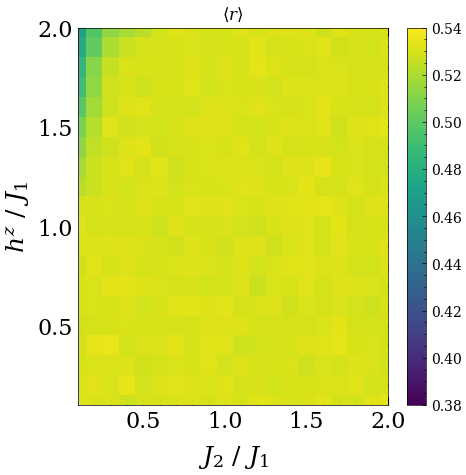

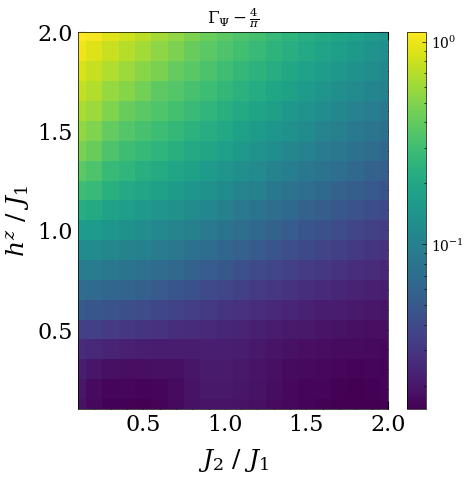

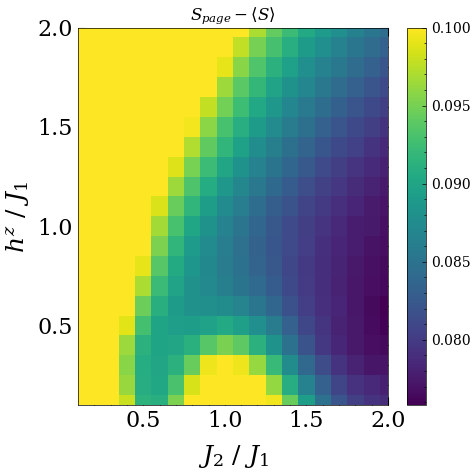

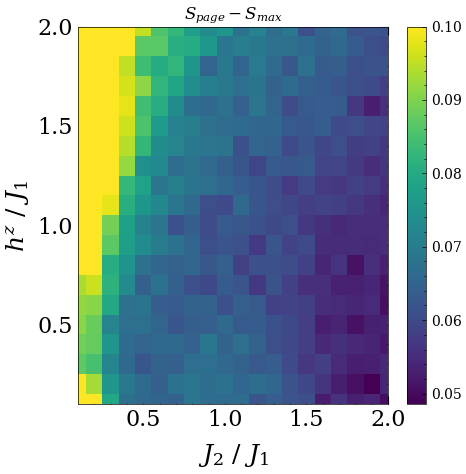

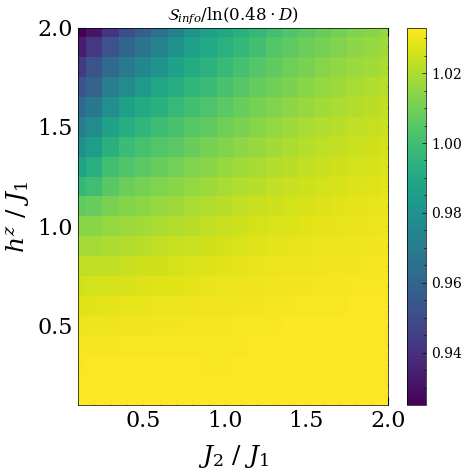

In [218]:

skipX = int(J_range.size / 6)
skipY = int(x_range.size / 6)

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gaps.pcolormesh(X, Y, gap_ratio_im, shading='nearest', vmin=0.38, vmax=0.54)
ax_gaps.set_title(r"$\langle r\rangle$")
fig.colorbar(p)

fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gauss.pcolormesh(X, Y, gaussianity_im, shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi - \frac{4}{\pi}$")
fig.colorbar(p)

fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_ent.pcolormesh(X, Y, ent_im, shading='nearest', vmax=0.1)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$")
fig.colorbar(p)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_outlier.pcolormesh(X, Y, ent_max_im, shading='nearest', vmax=0.1)
ax_outlier.set_title(r"$S_{page} - S_{max}$")
fig.colorbar(p)

fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_info.pcolormesh(X, Y, info_ent_im, shading='nearest')
ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
fig.colorbar(p)

for ax in [ax_info, ax_ent, ax_outlier, ax_gaps, ax_gauss]:

    hfun.set_plot_elements(axis = ax, ylabel = "h^z\ /\ J_1", xlabel = "J_2\ /\ J_1", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))

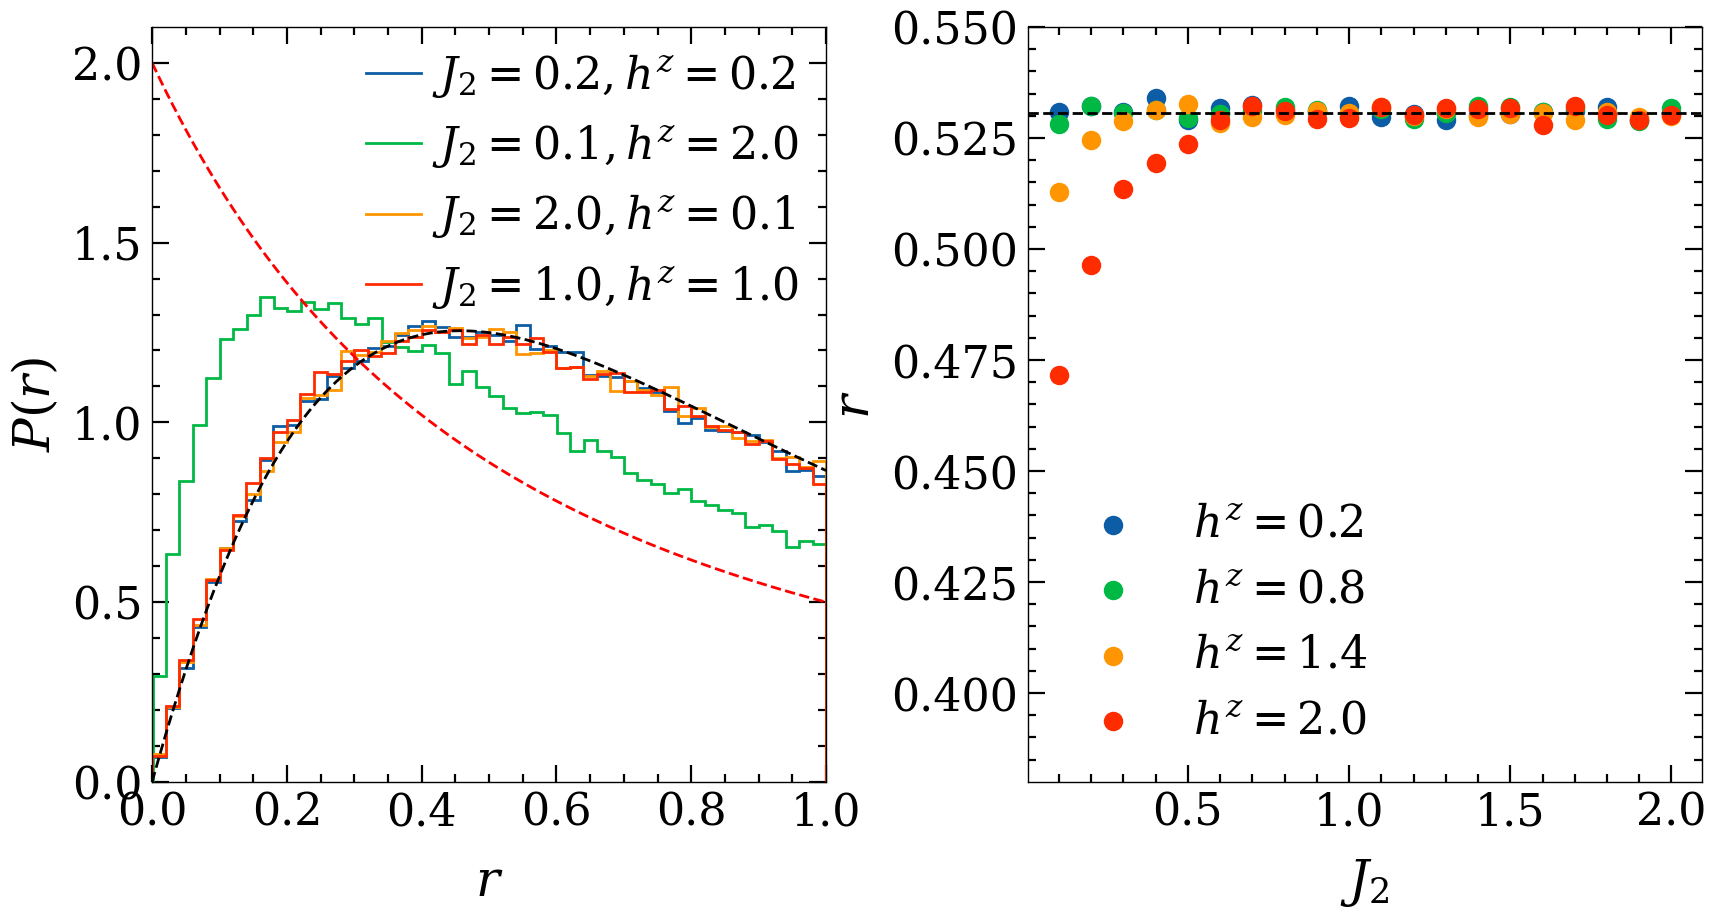

In [ ]:
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)


## --- LEFT PANEL
points_to_plot = [[0.2, 0.2], [0.1, 2.0], [2.0, 0.1], [1.0, 1.0]]
xpoi = np.linspace(0, 1, 100)
axis[0].plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black')
axis[0].plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red')

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(list(level_spacings_im[ii][jj]) + list(level_spacings[ii][jj]))
    wH = np.mean(gaps)
    gaps /= wH
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
    data = level_stats
    hist, bins = np.histogram(data, bins=50, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f$"%J2 + scan_lab + r"$=%.1f$"%(xx))
axis[0].set_xlim(0,1)    

## --- RIGHT PANEL

J_to_plot = [0.2, 0.8, 1.4, 2.0]
for J2 in J_to_plot:
    ii = list(J_range).index(J2)
    r = gap_ratio_im[ii]
    axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2))

axis[1].set_ylim(0.38, 0.55)
axis[1].axhline(y=0.5307, ls='--', color='black')


## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))


hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=True, xlim=(None, None), ylim=(None, None))
for ax in list(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)

fig.subplots_adjust(wspace=0.3, hspace=0.3)


## ALL SECTORS

In [219]:
ent_all = np.zeros((len(x_range), len(J_range)), dtype=np.float)
gauss_all = np.zeros((len(x_range), len(J_range)), dtype=np.float)
Smin = 1e10
indices = [0, 0]
for ii in range(len(x_range)):
   for jj in range(len(J_range)):
      dims_here_re = len(level_spacings[ii][jj]) + len(real_sectors)
      dims_here_im = len(level_spacings_im[ii][jj]) + len(imag_sectors)
      S = (dims_here_re * ent[ii, jj] + dims_here_im * ent_im[ii, jj]) / (dims_here_re + dims_here_im)
      if S < Smin: 
         Smin = S
         indices = [ii, jj]
      ent_all[ii, jj] = S
      gauss_all[ii, jj] = (gaussianity[ii, jj] + gaussianity_im[ii, jj])/2.

print(indices)
print(x_range[indices[0]], J_range[indices[1]])

[5, 19]
0.6 2.0


### COMBINE BY HAND

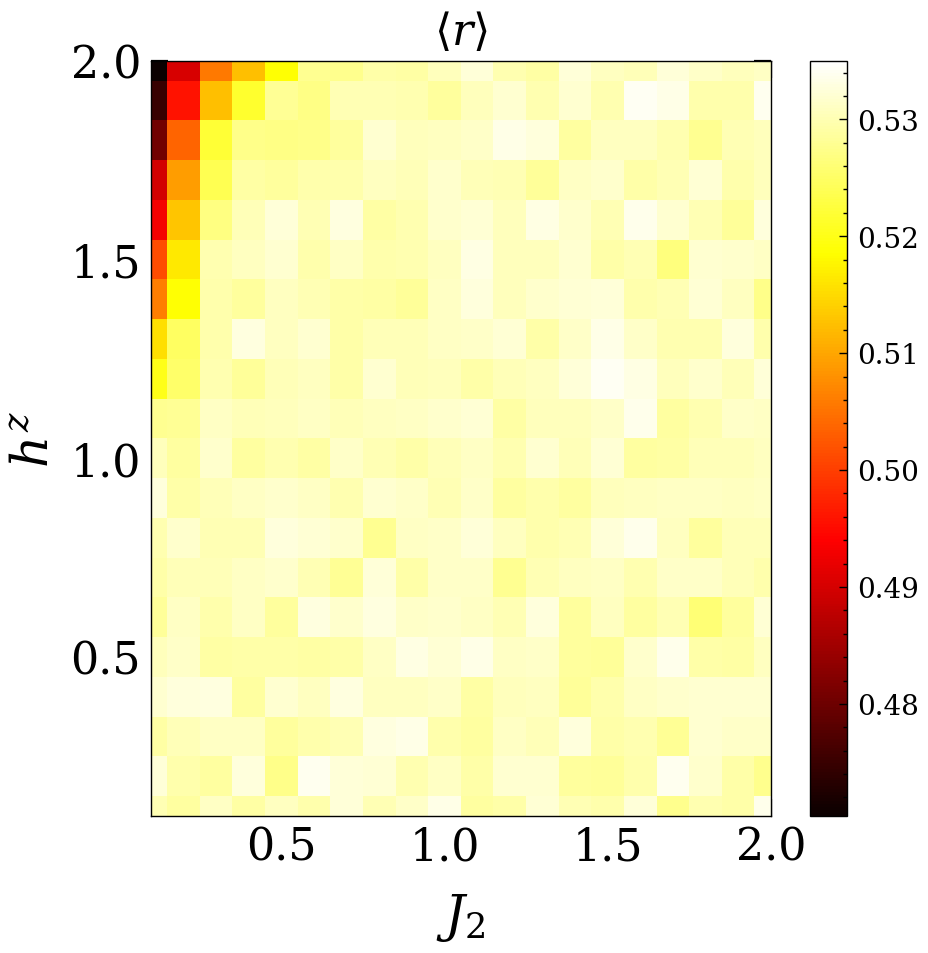

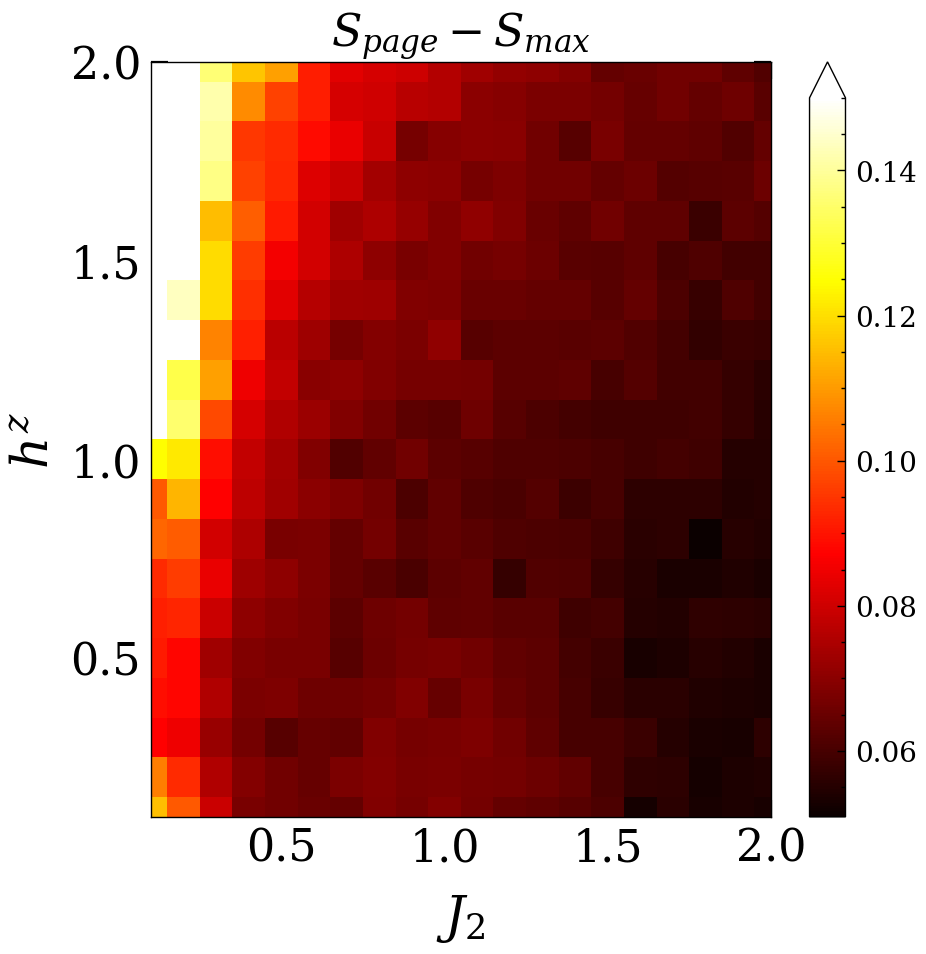

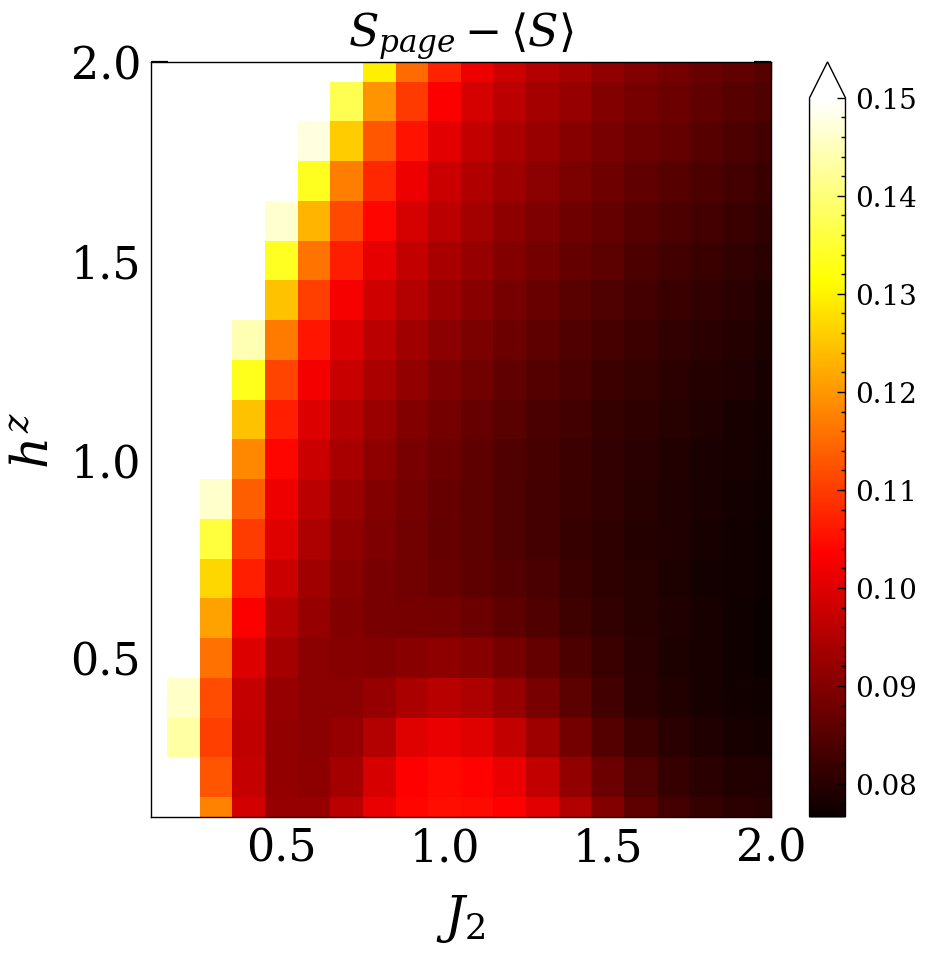

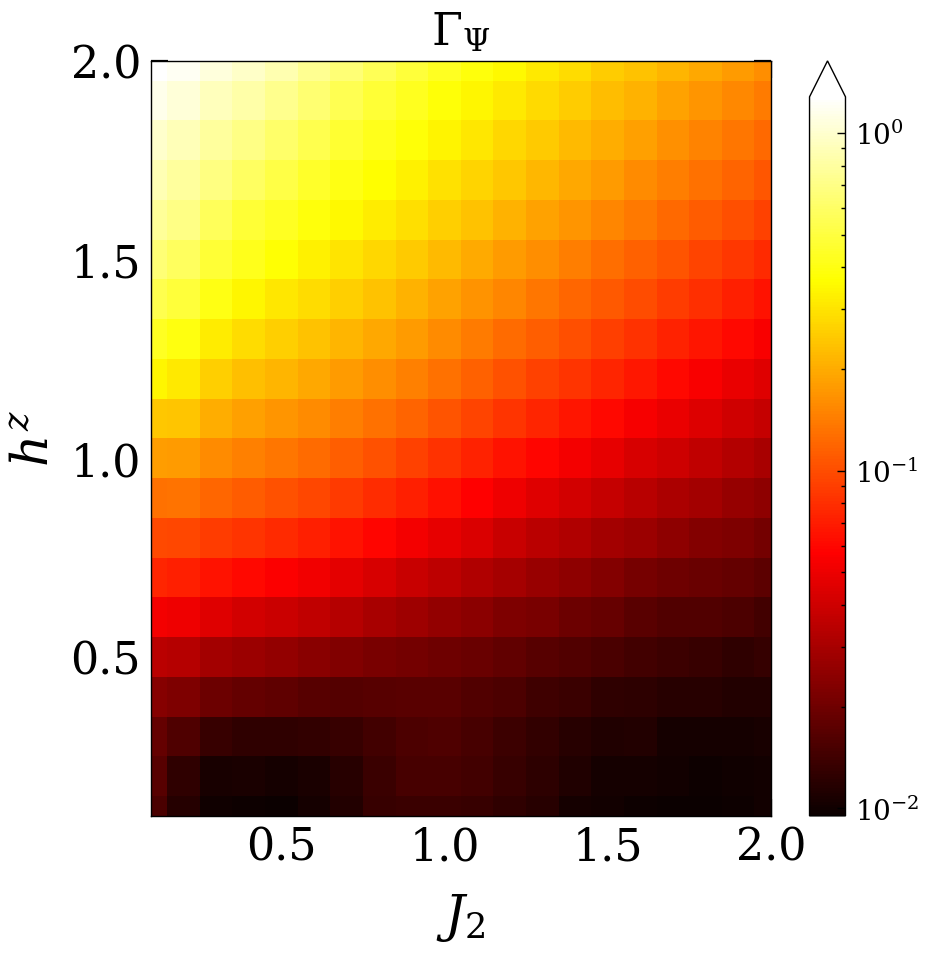

In [223]:

x_range = hfun.regspace(0.1, 2.1, 0.1)
J_range = hfun.regspace(0.1, 2.1, 0.1)
skipX = int(J_range.size / 4)
skipY = int(x_range.size / 4)

def add_stuff(ax):
    hfun.set_plot_elements(axis = ax, ylabel = "\\Delta_1" if use_Sz_sym else "h^z", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    tics = [0.5, 1.0, 1.5, 2.0]
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)
    ax.set_yticks(tics)
    ax.set_xticks(tics)
    ax.set_xlim(min(J_range), max(J_range))
    ax.set_ylim(min(x_range), max(x_range))

X, Y = np.meshgrid(J_range, x_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gaps.pcolormesh(X, Y, (gap_ratio + gap_ratio_im)/2, shading='nearest', vmax=0.535, cmap='hot')
ax_gaps.set_title(r"$\langle r\rangle$", fontsize=16)
add_stuff(ax_gaps)
fig.colorbar(p)
plt.savefig(f'Fig_r_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'Fig_r_map.png', bbox_inches = 'tight', padding=0.02)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_outlier.pcolormesh(X, Y, np.maximum(ent_max_im, ent_max), shading='nearest', vmax=0.15, cmap='hot')
ax_outlier.set_title(r"$S_{page} - S_{max}$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_outlier)
plt.savefig(f'Fig_entMax_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'Fig_entMax_map.png', bbox_inches = 'tight', padding=0.02)

#fig, ax_info = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
#p = ax_info.pcolormesh(X, Y, (info_ent + info_ent_im)/2, shading='nearest')
#ax_info.set_title(r"$\mathcal{S}_{info}/\ln(0.48\cdot D)$")
#fig.colorbar(p)


fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_ent.pcolormesh(X, Y, ent_all, cmap='hot', shading='nearest', vmax=0.15)
ax_ent.set_title(r"$S_{page} - \langle S\rangle$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_ent)
plt.savefig(f'Fig_ent_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'Fig_ent_map.png', bbox_inches = 'tight', padding=0.02)


fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
p = ax_gauss.pcolormesh(X, Y, gauss_all, cmap='hot', shading='nearest', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi$", fontsize=16)
fig.colorbar(p, extend='max')
add_stuff(ax_gauss)
plt.savefig(f'Fig_Gauss_map.pdf', bbox_inches = 'tight', padding=0.02)
plt.savefig(f'Fig_Gauss_map.png', bbox_inches = 'tight', padding=0.02)

#for ax in [ax_ent, ax_outlier, ax_gaps]:

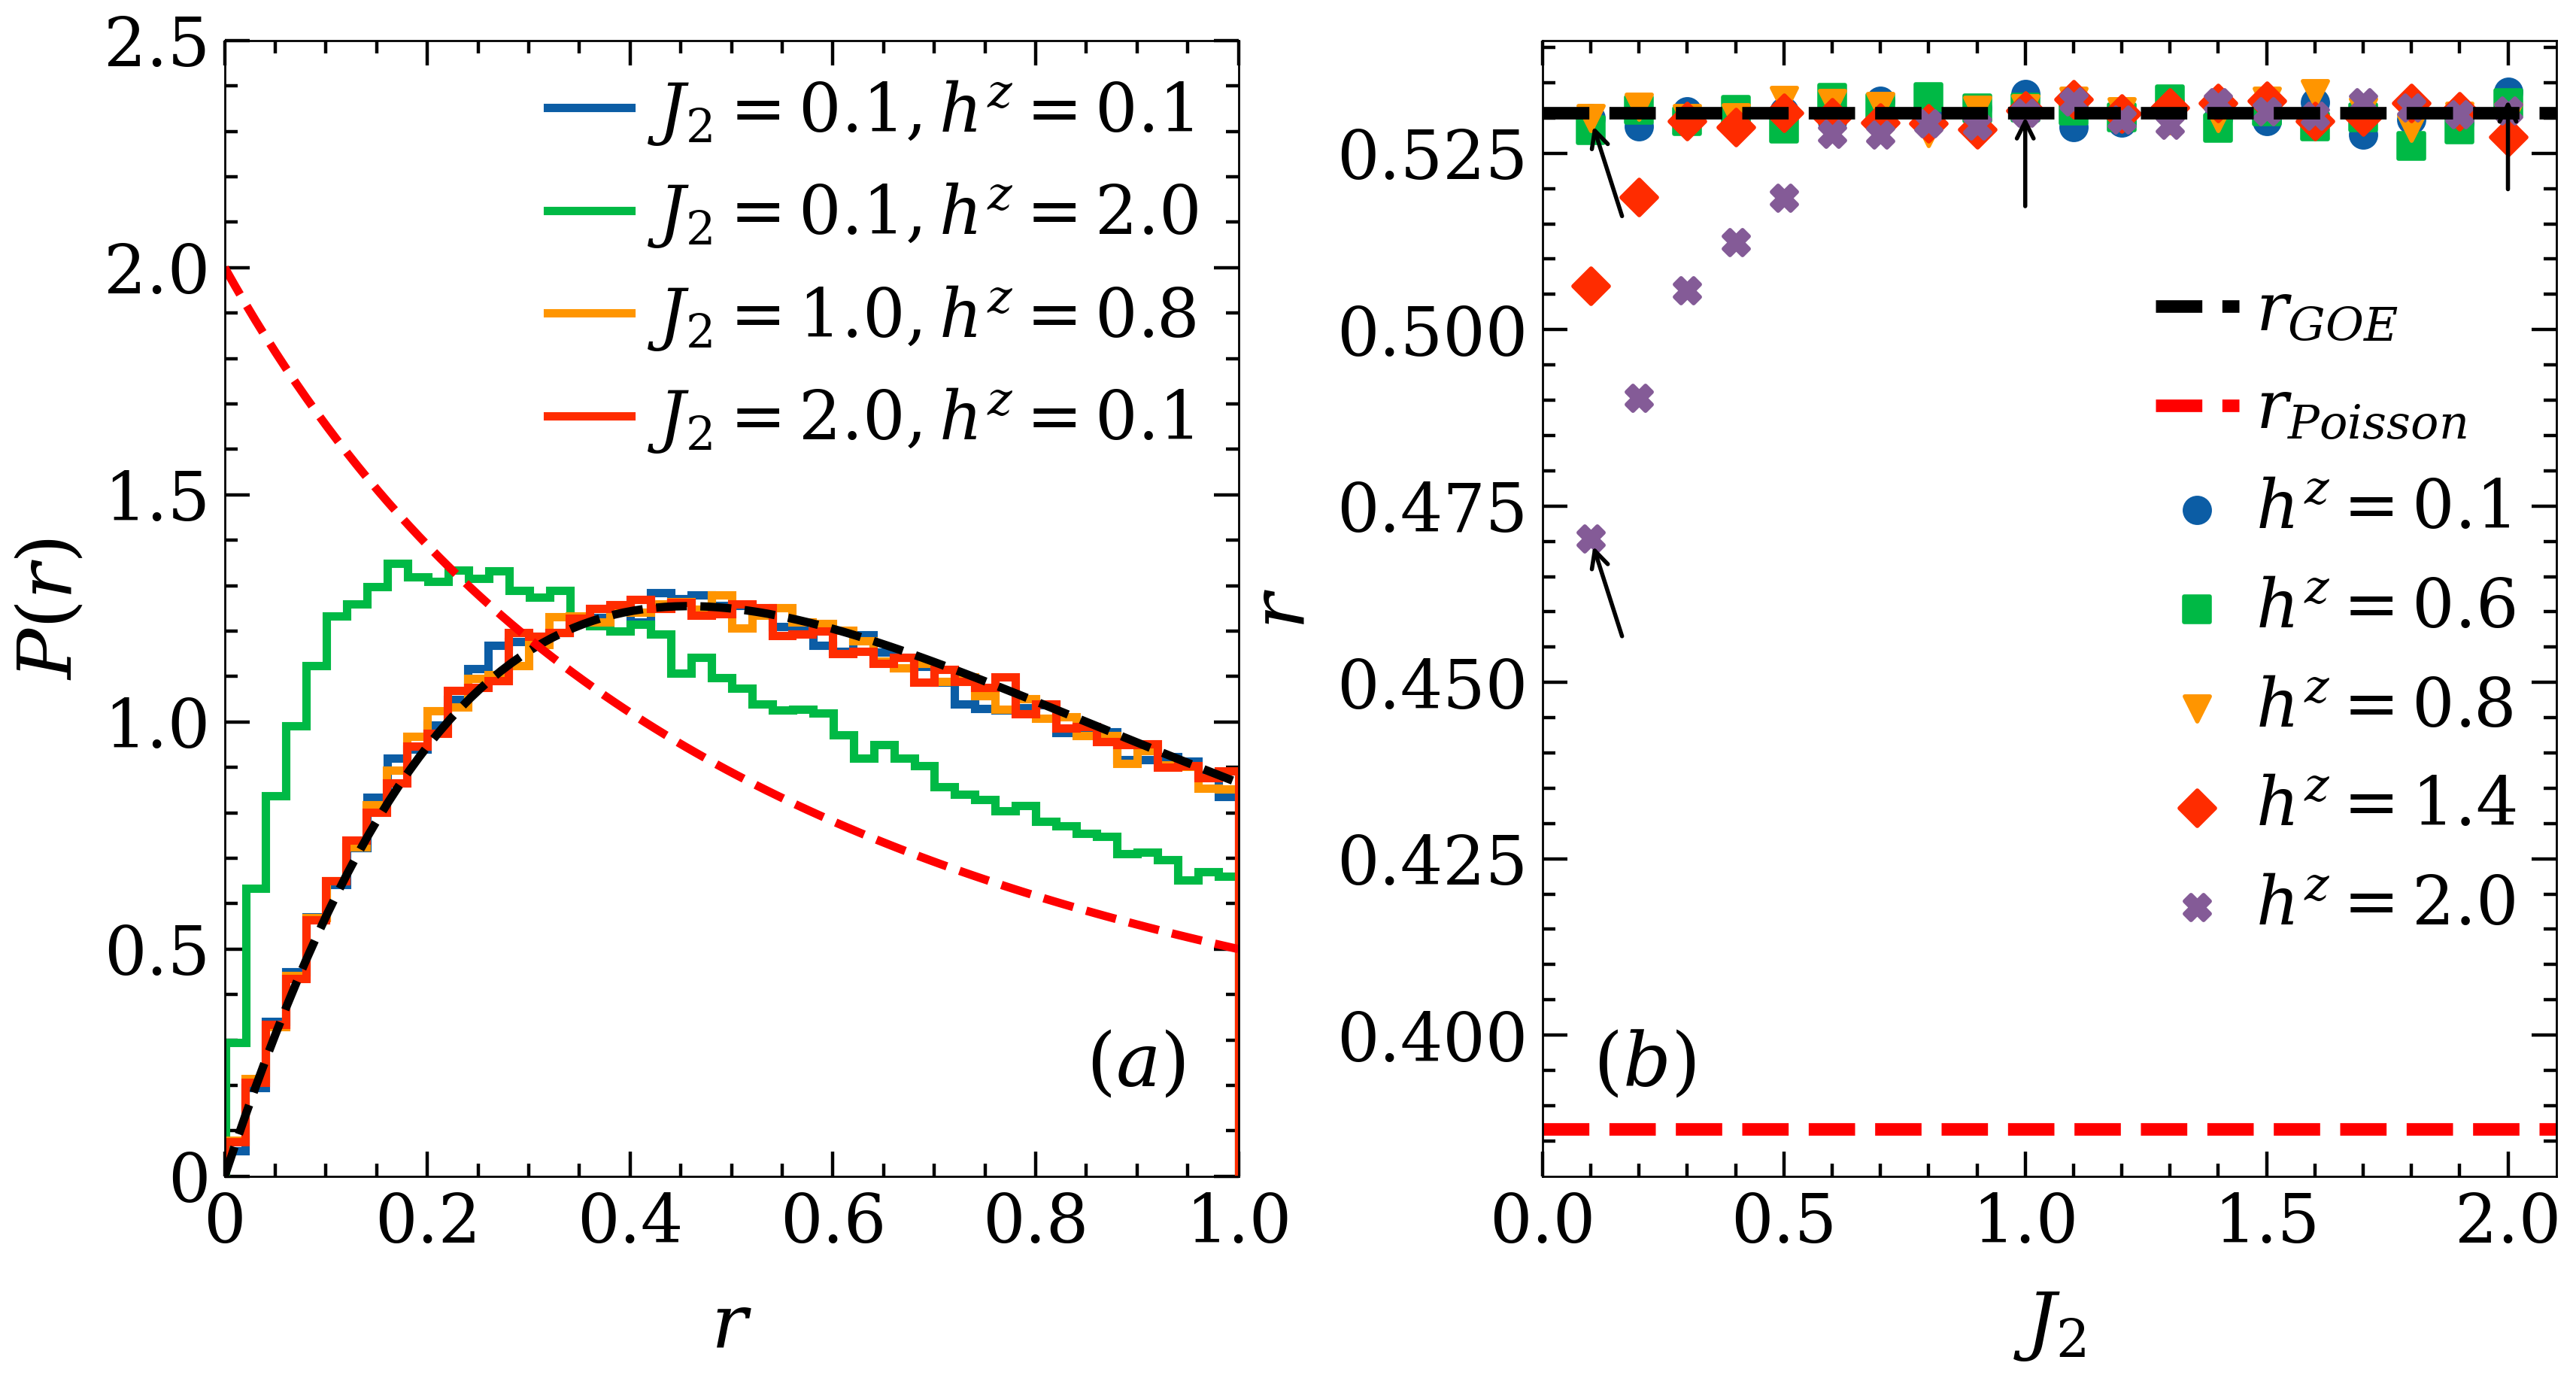

In [29]:
reload_modules()
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

#fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 100)
fig = plt.figure(figsize=(10,5), dpi = 400)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axis = [None, None]
axis[0] = fig.add_subplot(gs[0])
axis[1] = fig.add_subplot(gs[1])
## --- LEFT PANEL
points_to_plot = [[0.1, 0.1], [0.1, 2.0], [1.0, 0.8], [2.0, 0.1]]
xpoi = np.linspace(0, 1, 100)
axis[0].plot(xpoi, 27 / 4 * ( xpoi + xpoi**2 ) / ( 1 + xpoi + xpoi**2 )**(5/2), linestyle='--', color='black', linewidth=2)
axis[0].plot(xpoi, 2 / (1 + xpoi)**2, linestyle='--', color='red', linewidth=2)

for [J2, xx] in points_to_plot:
    ii = list(x_range).index(xx)
    jj = list(J_range).index(J2)
    gaps = np.array(list(level_spacings_im[ii][jj]) + list(level_spacings[ii][jj]))
    level_stats = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])

    hist, bins = np.histogram(level_stats, bins=50, normed=True)
    axis[0].stairs(hist, bins, label=r"$J_2=%.1f,$"%J2 + scan_lab + r"$=%.1f$"%(xx), linewidth=2)
    
    # ARROWS
    dx = 0.07 if J2 < 0.2 else 0
    r = (gap_ratio_im[ii] + gap_ratio[ii]) / 2.
    #r = np.mean(level_stats[ len(level_stats) // 4 : 3 * len(level_stats) // 4 ])
    axis[1].annotate("", xy=(J_range[jj], r[jj]), xytext=(dx + J_range[jj], r[jj] - 0.015), arrowprops=dict(arrowstyle="->"))

axis[0].set_xlim(0,1)    
axis[0].set_ylim(0.0,2.2)    

## --- RIGHT PANEL
h_to_plot = [0.1, 0.6, 0.8, 1.4, 2.0]
for idx, xx in enumerate(h_to_plot):
    ii = list(x_range).index(xx)
    r = (gap_ratio_im[ii] + gap_ratio[ii]) / 2.
    axis[1].scatter(J_range, r, label=r"$h^z=%.1f$"%(xx), marker=next(markers))

axis[1].set_ylim(0.38, 0.541)
axis[1].set_xlim(0.0,2.1)
axis[1].axhline(y=0.5307, ls='--', lw=3, color='black', label=r"$r_{GOE}$")
axis[1].axhline(y=0.3867, ls='--', lw=3, color='red', label=r"$r_{Poisson}$")

## --- COMSETICS
hfun.set_plot_elements(axis = axis[0], ylabel = "P(r)", xlabel = "r", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[0].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))


hfun.set_plot_elements(axis = axis[1], ylabel = "r", xlabel = "J_2", settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axis[1].legend(loc = 'center right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 0.5))
for ax in list(axis):
    ax.set_xscale('linear')    
    ax.set_yscale('linear')
    ax.tick_params(axis="both",which='major',direction="in",length=6, labelsize=16)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)


ticks = axis[0].get_yticks()   
tick_labels = ["%.1f"%ytic if ytic != 0.0 else "0" for ytic in ticks]
axis[0].set_yticks(ticks)
axis[0].set_yticklabels(tick_labels)

ticks = axis[0].get_xticks()   
tick_labels = ["%.1f"%ytic if ytic != 0.0 else "0" for ytic in ticks]
axis[0].set_xticks(ticks)
axis[0].set_xticklabels(tick_labels)

axis[0].annotate(r"$(a)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
axis[1].annotate(r"$(b)$", xy=(0.05, 0.08), fontsize=18, xycoords='axes fraction')
fig.subplots_adjust(wspace=0.3, hspace=0.3)


#plt.savefig("Fig_gap_ratio.pdf", bbox_inches = 'tight', pad_inches=0.02)
#plt.savefig("Fig_gap_ratio.png", bbox_inches = 'tight', pad_inches=0.02)

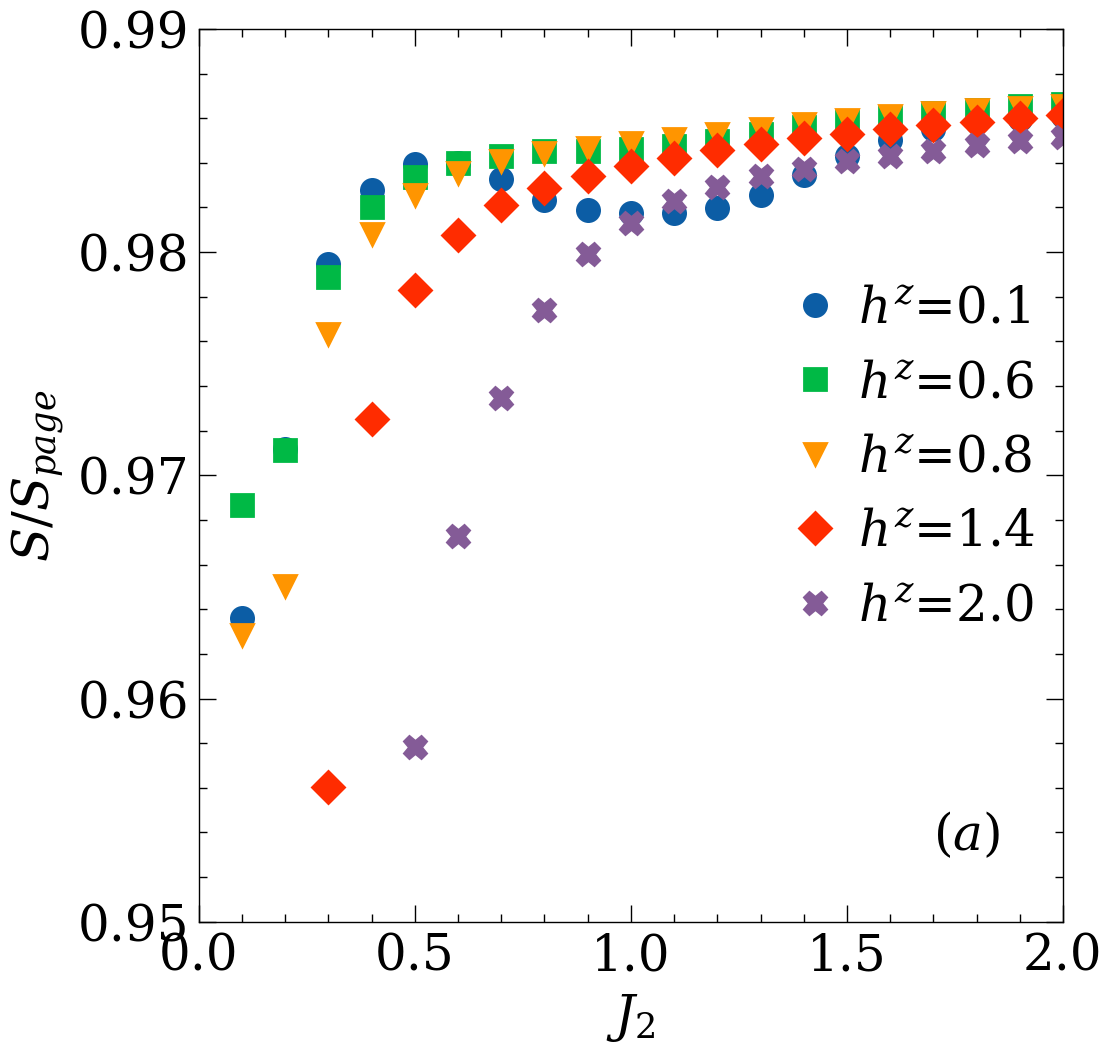

In [30]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.

# plot
fig, ax = plt.subplots(1, figsize = (5, 5), dpi=200)
fig.tight_layout()
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    ax.plot(J_range, (page(L, f) - ent_all[ii]) / page(L, f), label = f'{label_b}=${xx}$', linewidth=0, marker = next(markers), markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
ax.set_xlabel(label_a, size = 18)
ax.set_ylabel('$S / S_{page}$', size = 18)
ax.set_xlim(0.0,2.0)
ax.set_ylim(0.95, 0.99)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)

ax.tick_params(axis="both",which='major',direction="in", length=6)
ax.tick_params(axis="both",which='minor',direction="in", length=3)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
#ax.legend(fontsize = 18)
ax.legend(loc = 'center right', frameon=False, fontsize=18, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 0.52))

ax.annotate(r"$(a)$", xy=(0.85, 0.08), fontsize=18, xycoords='axes fraction')
plt.savefig("Fig_ent.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("Fig_ent.png", bbox_inches = 'tight', pad_inches=0.02)

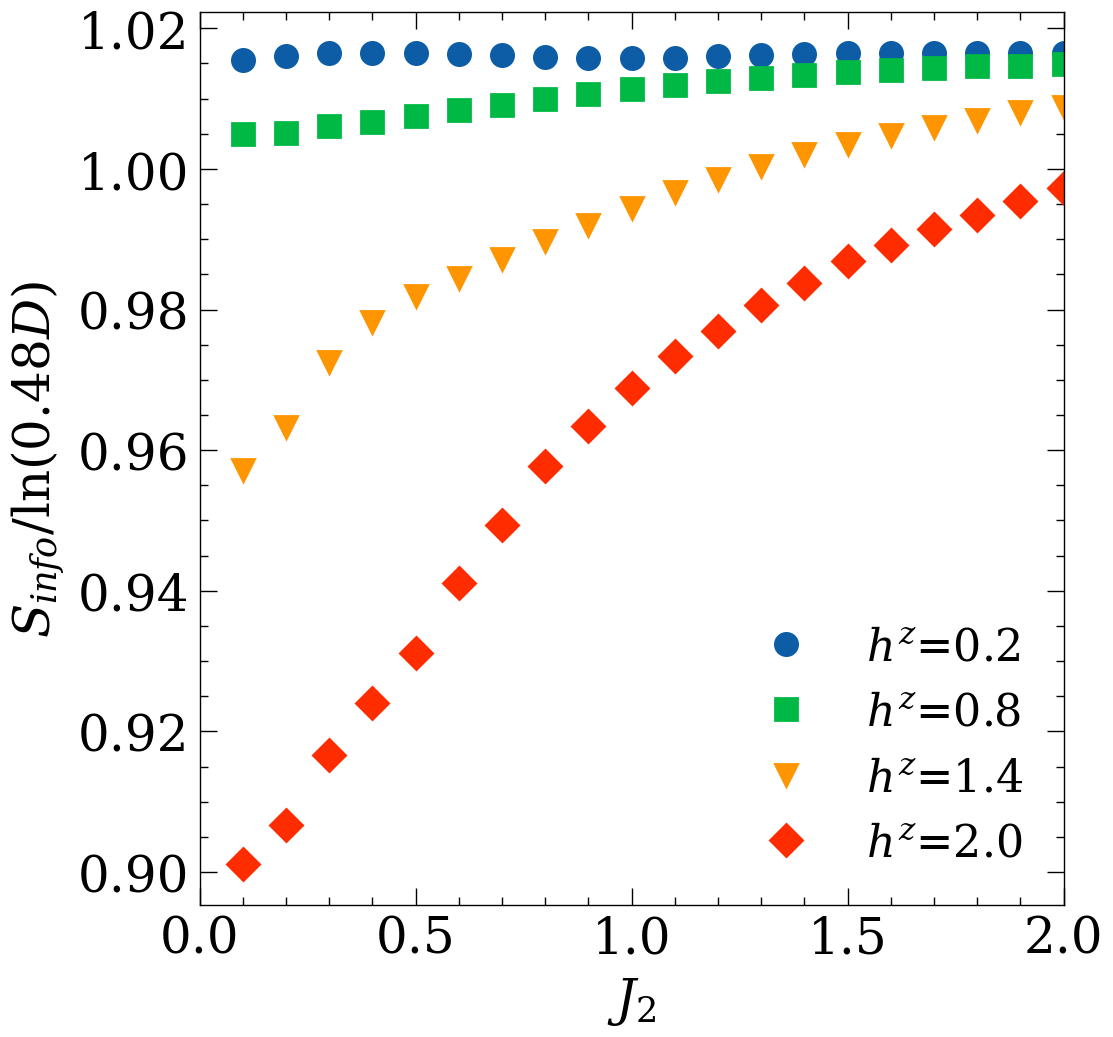

In [ ]:
markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

label_b = '$\Delta_1$' if use_Sz_sym else  '$h^z$'
label_a = '$J_2$'
f = 1/2.

# plot
fig, ax = plt.subplots(1, figsize = (5, 5), dpi=200)
fig.tight_layout()
for xx in h_to_plot:
    ii = list(x_range).index(xx)
    #axis[1].scatter(x_range[:-1], r, label=r"$h^z=%.1f$"%(J2), marker=next(markers))
    ax.plot(J_range, (info_ent + info_ent_im)[ii] / 2., label = f'{label_b}=${xx}$', linewidth=0, marker = next(markers), markersize=8)
    
#ax.axhline(goe, label = '$r_{GOE}$', linestyle = "--", linewidth=3, color='black')
ax.set_xlabel(label_a, size = 18)
ax.set_ylabel('$S_{info} / \ln(0.48D)$', size = 18)
ax.set_xlim(0.0,2.0)
#ax.set_ylim(1.015, 1.030)
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', rotation = 0, labelsize=18)

ax.tick_params(axis="both",which='major',direction="in", length=6)
ax.tick_params(axis="both",which='minor',direction="in", length=3)

#plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax.set_title(title)
ax.legend(fontsize = 16)

$J_2=2.0$

$h^z=0.2, 0.8, 1.5$

$L=14, 16,.., 20, 22$

# SIZE SCALING

In [7]:
hz_points = [0.2, 0.6, 0.8, 1.5] # hz or delta
J_points = [0.5, 1.0, 2.0]
num = 200
sizes = np.arange(16, 27, 2) if use_Sz_sym else np.arange(14, 24, 2)

J = 2.0
hz = 0.6
use_J_change = True

use_Sz_sym = False

def get_entropy_scaling(J, hz, get_states = False):

    S_re = []
    S_im = []
    dims_re = []
    dims_im = []

    S_max_re = []
    S_max_im = []

    edge = []
    hist = []
    gauss = []
    for L in sizes:

        real_sectors, imag_sectors = get_sectors(L)
        print(L, real_sectors, imag_sectors)
        hist_tmp = []
        edge_tmp = []

        ent_max_re = -1e10
        entropy_re = []
        coeffs_re_tmp = []
        dims_re_tmp = []
        for [ks, ps, xs] in real_sectors:
            status, energies, entropy, V = get_data(which=0, L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                    if get_states:  coeffs_re_tmp += list(V)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    dim = energies.size
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0:
                        my_min = 0;  
                        print(f'System size too small, dim(H)={dim}')

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if max(entropy) > ent_max_re: ent_max_re = max(entropy)
                    sample = entropy[my_min : my_max]

                    entropy_re.append(np.mean(sample))
                    dims_re_tmp.append(dim)
    
        ent_max_im = -1e10
        entropy_im = []
        coeffs_im_tmp = []
        dims_im_tmp = []
        for [ks, ps, xs] in imag_sectors:
            status, energies, entropy, V = get_data(which=1, L=L, J=J, xx=hz, 
                                                    ksym = ks, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                if get_states:  coeffs_im_tmp += 2 * list(V)
                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                dim = energies.size
                
                my_min = int(index_meanE - num / 2)
                if my_min < 0: 
                    my_min = 0;  
                    print(f'System size too small, dim(H)={dim}')

                my_max = int(index_meanE + num / 2) 
                if my_max >= dim: my_max = dim

                if max(entropy) > ent_max_im: ent_max_im = max(entropy)
                sample = entropy[my_min : my_max]

                entropy_im.append(np.mean(sample))
                entropy_im.append(np.mean(sample))
                dims_im_tmp.append(dim)
                dims_im_tmp.append(dim)

        print(entropy_im)
        S_re.append(np.array(entropy_re))
        S_im.append(np.array(entropy_im))

        dims_re.append(np.array(dims_re_tmp))
        dims_im.append(np.array(dims_im_tmp))
        
        S_max_re.append(np.nan if ent_max_re < 0 else ent_max_re)
        S_max_im.append(np.nan if ent_max_im < 0 else ent_max_im)

        coeffs = coeffs_re_tmp + coeffs_im_tmp
        hista, bins = np.histogram(coeffs, bins=200, normed=True)
        edge.append(bins)
        hist.append(hista)

        gauss.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)
     
    return S_re, S_im, S_max_re, S_max_im, dims_re, dims_im, edge, hist, gauss


In [8]:
num = 200
sizes_obc = np.arange(12, 22, 2) if use_Sz_sym else np.arange(10, 20, 2)

J = 2.0
hz = 0.6
use_J_change = True

use_Sz_sym = False

def get_entropy_scaling_obc(J, hz, get_states = False):

    S_obc = []
    dims_obc = []
    S_max_obc = []

    edge_obc = []
    hist_obc = []
    gauss_obc = []
    for L in sizes_obc:

        real_sectors, imag_sectors = get_sectors(L)
        print(L, real_sectors)
        hist_tmp = []
        edge_tmp = []

        ent_max = -1e10
        entropy_tmp = []
        coeffs = []
        dims_tmp = []
        for [ks, ps, xs] in real_sectors:
            status, energies, entropy, V = get_data_obc(L=L, J=J, xx=hz, psym = ps, xsym=xs, 
                                                    get_states=get_states, use_Sz_sym=use_Sz_sym)
            if status:
                    if get_states:  coeffs += list(V)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    dim = energies.size
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0:
                        my_min = 0;  
                        print(f'System size too small, dim(H)={dim}')

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if max(entropy) > ent_max: ent_max = max(entropy)
                    sample = entropy[my_min : my_max]

                    entropy_tmp.append(np.mean(sample))
                    dims_tmp.append(dim)

        print(entropy_tmp)
        S_obc.append(np.array(entropy_tmp))

        dims_obc.append(np.array(dims_tmp))
        
        S_max_obc.append(np.nan if ent_max < 0 else ent_max)
        if get_states:
            hista, bins = np.histogram(coeffs, bins=200, normed=True)
            edge_obc.append(bins)
            hist_obc.append(hista)
            gauss_obc.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2)

    return S_obc, S_max_obc, dims_obc, edge_obc, hist_obc, gauss_obc

In [55]:
J2 = 1.0
hz = 0.6
S_re, S_im, S_max_re, S_max_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False)
S_obc, S_max_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False)
print(dims_re)
print(dims_im)
print(dims_obc)

14 [[0, -1, 1], [0, 1, 1], [7, -1, 1], [7, 1, 1]] [[1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1]]
[4.243300934952803, 4.243300934952803, 4.242594846019515, 4.242594846019515, 4.245116364401916, 4.245116364401916, 4.24135439140606, 4.24135439140606, 4.2439267181657865, 4.2439267181657865, 4.243527941860825, 4.243527941860825]
16 [[0, -1, 1], [0, 1, 1], [8, -1, 1], [8, 1, 1]] [[1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1]]
[4.953663180540169, 4.953663180540169, 4.951343527583521, 4.951343527583521, 4.951041372089777, 4.951041372089777, 4.951108584837718, 4.951108584837718, 4.951429782739314, 4.951429782739314, 4.9491176438164795, 4.9491176438164795, 4.952040889602662, 4.952040889602662]
18 [[0, -1, 1], [0, 1, 1], [9, -1, 1], [9, 1, 1]] [[1, 1, 1], [2, 1, 1], [3, 1, 1], [4, 1, 1], [5, 1, 1], [6, 1, 1], [7, 1, 1], [8, 1, 1]]
[5.650955571629711, 5.650955571629711, 5.651712188163899, 5.651712188163899, 5.652304951816071, 5.652304951816071, 5.6

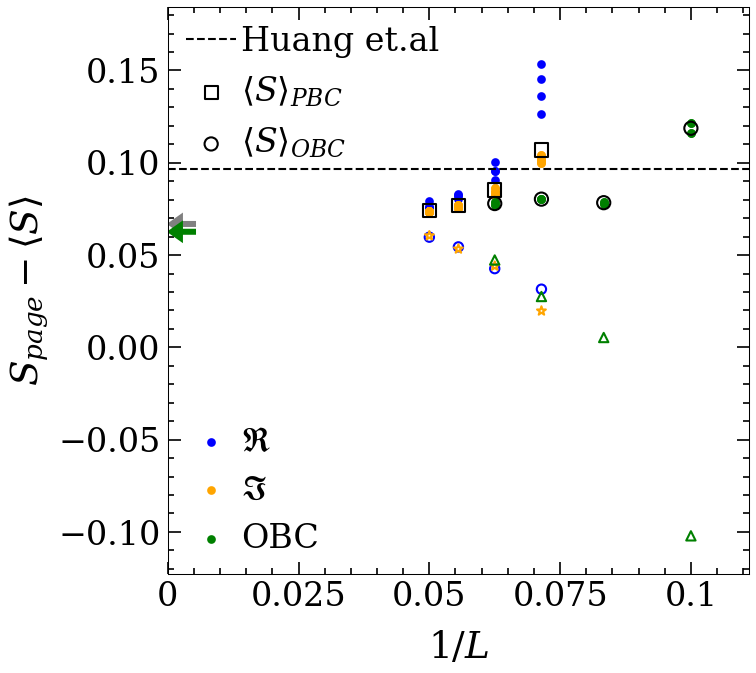

In [123]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 150)
f = 0.5
S_tot = []

use_raw_size = True
def rescaler(dim):
    return dim if use_raw_size else np.log2(dim)

for i, L in enumerate(sizes):
    S_tot_tmp = 0
    dims = 0
    for jj, Sre in enumerate(S_re[i]): 
        if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sre, color='blue', s=10, label = r"$\Re$")
        else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sre, color='blue', s=10)
        S_tot_tmp += Sre * rescaler(dims_re[i][jj])
        dims += rescaler(dims_re[i][jj])

    for jj, Sim in enumerate(S_im[i]): 
        if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sim, color='orange', s=10, label = r"$\Im$")
        else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sim, color='orange', s=10)
        S_tot_tmp += Sim * rescaler(dims_im[i][jj])
        dims += rescaler(dims_im[i][jj])

    S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
S_tot_obc = []
for i, L in enumerate(sizes_obc):
    S_tot_tmp = 0
    dims = 0
    print(S_obc[i])
    for jj, So in enumerate(S_obc[i]):
        if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - So, color='green', s=10, label = 'OBC')
        else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - So, color='green', s=10)
        S_tot_tmp += So * rescaler(dims_obc[i][jj])
        dims += rescaler(dims_obc[i][jj])
    S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
   
thermodynamic_value_pbc = page_result(f * 20, (1-f)*20) - (S_tot[-2] + np.maximum(S_max_re[-2], S_max_im[-2])) / 2.
thermodynamic_value_obc = page_result(f * 16, (1-f)*16) - (S_tot_obc[-2] + S_max_obc[-2]) / 2.
print(thermodynamic_value_obc, thermodynamic_value_pbc)

axis.arrow(x=0.005, y=thermodynamic_value_pbc, dx=-0.0025, dy=0, color='gray', head_length=0.002, head_width=0.008, lw=2)
axis.arrow(x=0.005, y=thermodynamic_value_obc, dx=-0.0025, dy=0, color='green', head_length=0.002, head_width=0.008, lw=2)
    
axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_tot, color='black', facecolor='None', marker='s', s=40, label=r"$\langle S\rangle_{PBC}$")
axis.scatter(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_tot_obc, color='black', facecolor='None', marker='o', s=40, label=r"$\langle S\rangle_{OBC}$")

axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_max_re, color='blue', facecolor='None', marker='o', s=20)#, label='outlier real sectors')
axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_max_im, color='orange', facecolor='None', marker='*', s=20)#, label='outlier imag sectors')
axis.scatter(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max_obc, color='green', facecolor='None', marker='^', s=20)#, label='outlier imag sectors')
axis.axhline(y = 0.096574, linestyle='--', color='black', label='Huang et.al')

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

y_min = 1.2 * (page_result(f * sizes_obc[0], (1-f)*sizes_obc[0]) - S_max_obc[0])
y_max = 1.2 * np.max(page_result(f * sizes[0], (1-f)*sizes[0]) - S_re[0])
hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 1/9), ylim=(y_min, y_max))

handles, labels = axis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
legend = axis.legend(handles[[0,4,5]], labels[[0,4,5]], fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
axis.legend(handles[[1,2,3]], labels[[1,2,3]], fontsize=16, loc='lower left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, -0.02))
plt.gca().add_artist(legend)
xtic = axis.get_xticks()
tick_labels = ["%d"%tic if tic == 0 else "%g"%tic for tic in xtic]
axis.set_xticklabels(tick_labels)
axis.tick_params(axis='both', which='major', labelsize=16, length=6)
axis.tick_params(axis='both', which='minor', labelsize=16, length=3)


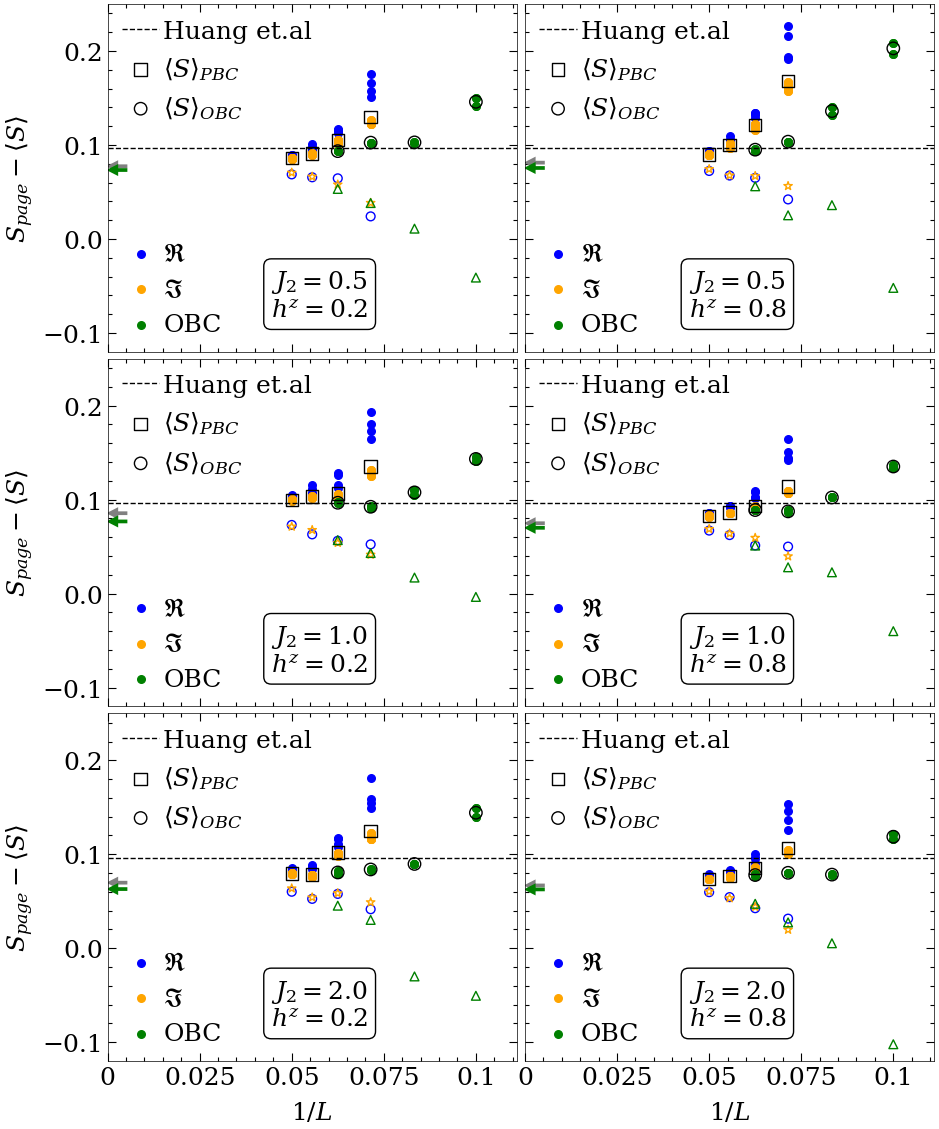

In [124]:
NCOLS=2
NROWS=3
space=0.02
import sys
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

num_of_subplots = NROWS * NCOLS
fig, axes = plt.subplots( nrows=NROWS, ncols=NCOLS, figsize=(16 * (NCOLS / NROWS),14), dpi = 100, sharex=True, sharey=True)
axes = axes.flatten()
my_pars = [[0.5, 0.2], [0.5, 0.8], [1.0, 0.2], [1.0, 0.8], [2.0, 0.2], [2.0, 0.8]]
for ii, [J2, hz] in enumerate(my_pars):
    axis = axes[ii]
    blockPrint()
    S_re, S_im, S_max_re, S_max_im, dims_re, dims_im, _, _, _ = get_entropy_scaling(J2, hz, get_states=False)
    S_obc, S_max_obc, dims_obc, _, _, _ = get_entropy_scaling_obc(J2, hz, get_states=False)
    enablePrint()
    f = 0.5
    S_tot = []

    use_raw_size = True
    def rescaler(dim):
        return dim if use_raw_size else np.log2(dim)

    for i, L in enumerate(sizes):
        S_tot_tmp = 0
        dims = 0
        for jj, Sre in enumerate(S_re[i]): 
            if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sre, color='blue', s=30, label = r"$\Re$")
            else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sre, color='blue', s=30)
            S_tot_tmp += Sre * rescaler(dims_re[i][jj])
            dims += rescaler(dims_re[i][jj])

        for jj, Sim in enumerate(S_im[i]): 
            if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sim, color='orange', s=30, label = r"$\Im$")
            else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - Sim, color='orange', s=30)
            S_tot_tmp += Sim * rescaler(dims_im[i][jj])
            dims += rescaler(dims_im[i][jj])

        S_tot.append(S_tot_tmp / dims if dims > 0 else np.nan)
    S_tot_obc = []
    for i, L in enumerate(sizes_obc):
        S_tot_tmp = 0
        dims = 0
        for jj, So in enumerate(S_obc[i]):
            if i == 0 and jj == 0:  axis.scatter(1. / L, page_result(f * L, (1-f)*L) - So, color='green', s=30, label = 'OBC')
            else:                   axis.scatter(1. / L, page_result(f * L, (1-f)*L) - So, color='green', s=30)
            S_tot_tmp += So * rescaler(dims_obc[i][jj])
            dims += rescaler(dims_obc[i][jj])
        S_tot_obc.append(S_tot_tmp / dims if dims > 0 else np.nan)
    
    thermodynamic_value_pbc = page_result(f * 20, (1-f)*20) - (S_tot[-2] + np.maximum(S_max_re[-2], S_max_im[-2])) / 2.
    thermodynamic_value_obc = page_result(f * 16, (1-f)*16) - (S_tot_obc[-2] + S_max_obc[-2]) / 2.
    
    print(f'J2={J2}, hz={hz}', thermodynamic_value_obc, thermodynamic_value_pbc)

    axis.arrow(x=0.005, y=thermodynamic_value_pbc, dx=-0.0025, dy=0, color='gray', head_length=0.002, head_width=0.008, lw=2)
    axis.arrow(x=0.005, y=thermodynamic_value_obc, dx=-0.0025, dy=0, color='green', head_length=0.002, head_width=0.008, lw=2)
    
    axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_tot, color='black', facecolor='None', marker='s', s=80, label=r"$\langle S\rangle_{PBC}$")
    axis.scatter(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_tot_obc, color='black', facecolor='None', marker='o', s=80, label=r"$\langle S\rangle_{OBC}$")

    axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_max_re, color='blue', facecolor='None', marker='o', s=40)#, label='outlier real sectors')
    axis.scatter(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_max_im, color='orange', facecolor='None', marker='*', s=40)#, label='outlier imag sectors')
    axis.scatter(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max_obc, color='green', facecolor='None', marker='^', s=40)#, label='outlier imag sectors')
    axis.axhline(y = 0.096574, linestyle='--', color='black', label='Huang et.al')

    new_set_class = copy.deepcopy(cf.plot_settings)
    new_set_class.set_scales(xscale='linear', yscale='linear')
    settings = getattr(new_set_class, 'settings')

    ylab = "S_{page}-\\langle S\\rangle" if ii % NCOLS == 0 else "\ "
    xlab = "1/L" if ii >= NCOLS*(NROWS-1) else "\ "
    hfun.set_plot_elements(axis = axis, ylabel = ylab, xlabel = xlab, settings=settings, 
                            font_size=16, set_legend=False, xlim=(0, 1/9), ylim=(-0.12, 0.25))

    handles, labels = axis.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    legend = axis.legend(handles[[0,4,5]], labels[[0,4,5]], fontsize=18, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, 1.02))
    axis.legend(handles[[1,2,3]], labels[[1,2,3]], fontsize=18, loc='lower left', ncol=1, handletextpad=0.15, handlelength = 1.5, bbox_to_anchor=(-0.02, -0.02))
    axis.add_artist(legend)
    xtic = axis.get_xticks()
    tick_labels = ["%d"%tic if tic == 0 else "%g"%tic for tic in xtic]
    axis.set_xticklabels(tick_labels)

    
    axis.annotate(r"$J_2=%.1f$"%J2 + "\n" + r"$h^z=%.1f$"%hz, xy=(0.4, 0.1), fontsize=18, xycoords='axes fraction', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

    axis.tick_params(axis='both', which='major', labelsize=18, length=6)
    axis.tick_params(axis='both', which='minor', labelsize=18, length=3)
fig.subplots_adjust(wspace=space, hspace=space)

In [ ]:
S_re_list = []
S_im_list = []
S_max_re_list = []
S_max_im_list = []
dims_re_list = []
dims_im_list = []
edges = []
histograms = []
gaussianity = []


J2=0.5
hz=0.2

x_points = J_points if use_J_change else hz_points
print(x_points)
pars = []
for J2 in J_points:
    for hz in hz_points:
        pars.append([J2, hz])
        S_re_tmp, S_im_tmp, S_max_re_tmp, S_max_im_tmp, dims_re_tmp, dims_im_tmp, edge, hist, gauss = get_entropy_scaling(J2, hz, get_states=True)
        S_re_list.append(S_re_tmp)
        S_im_list.append(S_im_tmp)
        S_max_re_list.append(S_max_re_tmp)
        S_max_im_list.append(S_max_im_tmp)
        dims_re_list.append(dims_re_tmp)
        dims_im_list.append(dims_im_tmp)
        edges.append(edge)
        histograms.append(hist)
        gaussianity.append(gauss)   

In [20]:
S_obc_list = []
S_max_obc_list = []
dims_obc_list = []
edges_onc = []
hist_obc = []
gauss_obc = []

pars = []
for J2 in J_points:
    for hz in hz_points:
        pars.append([J2, hz])
        S_obc, S_max_obc, dims_obc, edge_obc, his_obc, gaga_obc = get_entropy_scaling_obc(J2, hz, get_states=True)
        S_obc_list.append(S_obc)
        S_max_obc_list.append(S_max_obc)
        dims_obc_list.append(dims_obc)
        edges_onc.append(edge_obc)
        hist_obc.append(his_obc)
        gauss_obc.append(gaga_obc)  

10 [[0, -1, 1], [0, 1, 1], [5, -1, 1], [5, 1, 1]]
0.5 0.2 	 -1 	 (201, 497) 	 -1.1784040478217926e-06
0.5 0.2 	 1 	 (201, 529) 	 -1.7206397250365928e-06
0.5 0.2 	 -1 	 (201, 497) 	 -1.1784040478217926e-06
0.5 0.2 	 1 	 (201, 529) 	 -1.7206397250365928e-06
[2.8161869567754536, 2.8243281365975745, 2.8161869567754536, 2.8243281365975745]
12 [[0, -1, 1], [0, 1, 1], [6, -1, 1], [6, 1, 1]]
0.5 0.2 	 -1 	 (201, 2017) 	 -1.0794224939672959e-07
0.5 0.2 	 1 	 (201, 2081) 	 -1.2095954844785215e-07
0.5 0.2 	 -1 	 (201, 2017) 	 -1.0794224939672959e-07
0.5 0.2 	 1 	 (201, 2081) 	 -1.2095954844785215e-07
[3.555876840309787, 3.5566086841431557, 3.555876840309787, 3.5566086841431557]
14 [[0, -1, 1], [0, 1, 1], [7, -1, 1], [7, 1, 1]]
0.5 0.2 	 -1 	 (201, 8129) 	 -2.7845002501935157e-09
0.5 0.2 	 1 	 (201, 8257) 	 -4.793480926467276e-09
0.5 0.2 	 -1 	 (201, 8129) 	 -2.7845002501935157e-09
0.5 0.2 	 1 	 (201, 8257) 	 -4.793480926467276e-09
[4.249435295972669, 4.249686725768098, 4.249435295972669, 4.249686

Let's start
Let's start
J2=0.5, hz=0.2
J2=0.5, hz=0.6
J2=0.5, hz=0.8
J2=0.5, hz=1.5


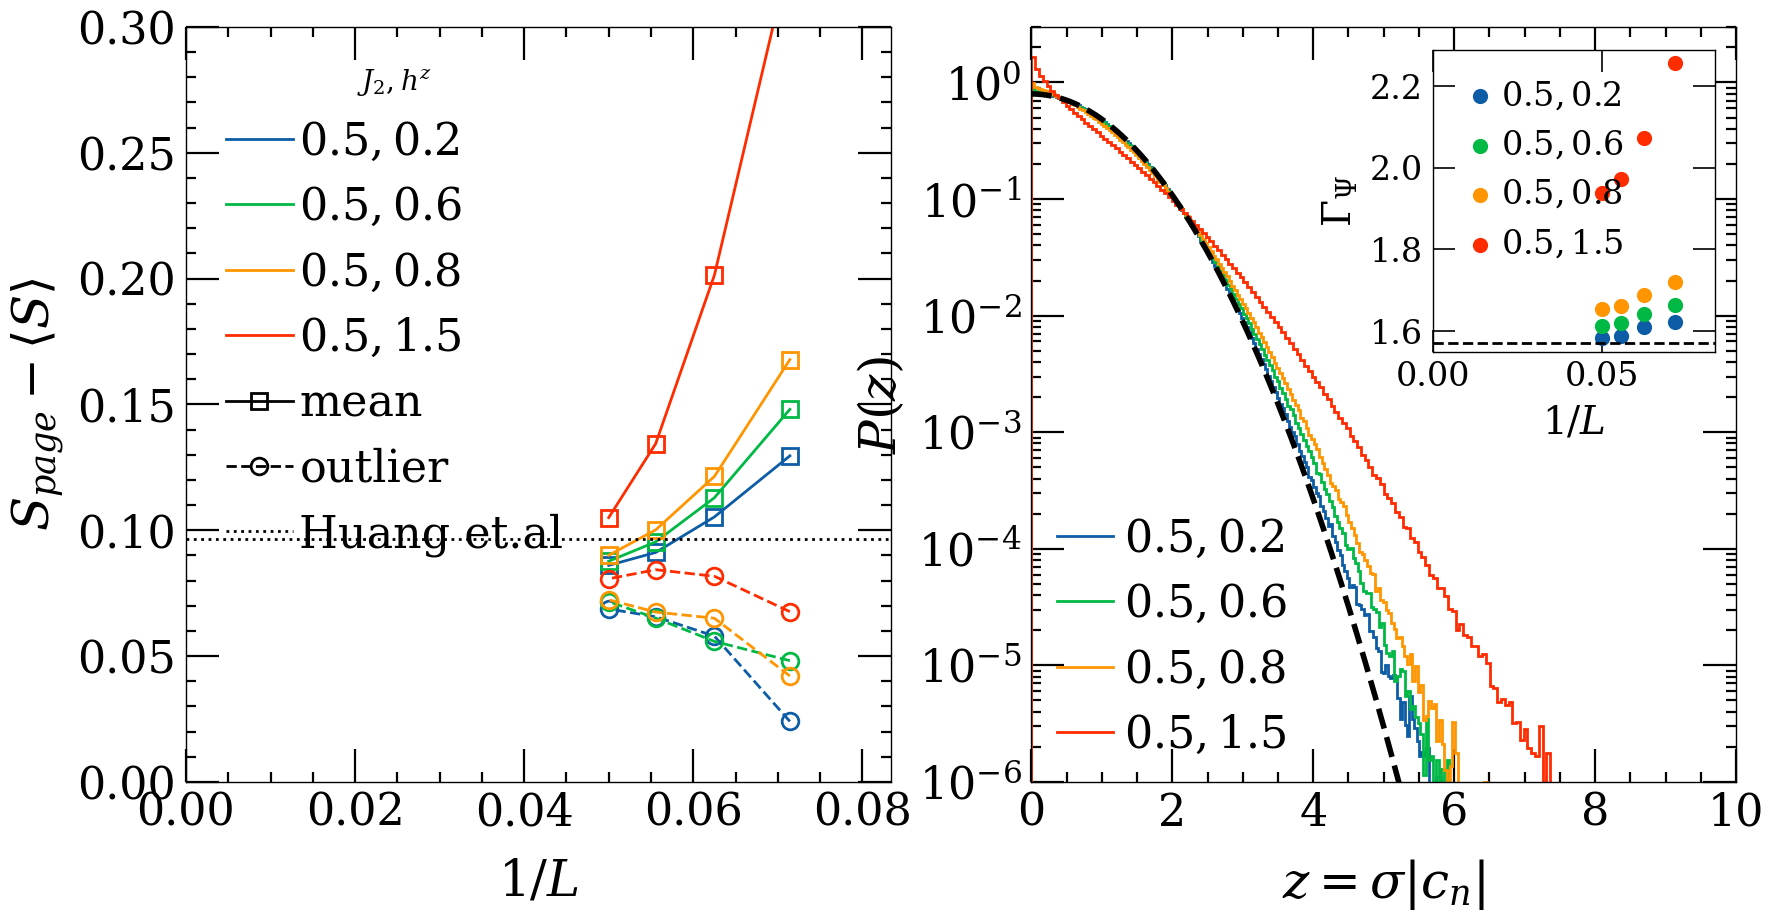

In [19]:
print("Let's start")
fig = plt.figure(figsize=(10,5), dpi = 200)

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axes = [None, None]
axes[0] = fig.add_subplot(gs[0])
axes[1] = fig.add_subplot(gs[1])

plot_abs = False

width = 0.4
height = 0.4
ax_inset = hfun.add_subplot_axes(axes[1], [0.97 - width, 0.97 - height, width, height])
print("Let's start")
axis = axes[0]
colors = ['blue', 'black', 'green', 'red']
def lablab(val):
    return r"$J_2=%.1f$"%val if use_J_change else r"$h^z=%.1f$"%val
f=0.5

#for ii, xx in enumerate(x_points):
my_pars = [[0.5, hz] for hz in hz_points]
for [J2, hz] in my_pars:
    ii = pars.index([J2, hz])
    print(f'J2={J2}, hz={hz}')
    S_real = S_re_list[ii]
    S_imag = S_im_list[ii]
    S_max_real = S_max_re_list[ii]
    S_max_imag = S_max_im_list[ii]
    dims_real =  dims_re_list[ii]
    dims_imag =  dims_im_list[ii]
    edge = edges[ii]
    hist = histograms[ii]
    S_total = []
    for i, L in enumerate(sizes):
        S_tot_tmp = 0
        dims = 0
        for jj, Sre in enumerate(S_real[i]): 
            S_tot_tmp += Sre * dims_real[i][jj]
            dims += dims_real[i][jj]

        for jj, Sim in enumerate(S_imag[i]): 
            S_tot_tmp += Sim * dims_imag[i][jj]
            dims += dims_imag[i][jj]
        
        S_total.append(S_tot_tmp / dims if dims > 0 else np.nan)
        
    p = axis.plot(1. / sizes, page_result(f * sizes, (1-f)*sizes) - S_total, markerfacecolor='None', marker='s', markersize=6)
    axis.plot(1. / sizes, page_result(f * sizes, (1-f)*sizes) - np.maximum(S_max_real, S_max_imag), color = p[0].get_color(), markerfacecolor='None', marker='o', linestyle='--', markersize=6)
    axis.plot(np.nan, np.nan, color = p[0].get_color(), label=r"$%.1f,%.1f$"%(J2, hz))

    axes[1].stairs(hist[-2], edge[-2], label=r"$%.1f,%.1f$"%(J2, hz))
    for jj in range(len(edge)):
        if jj == 0:     ax_inset.scatter(1/sizes[jj], gaussianity[ii][jj], color=p[0].get_color(), s=20, label=r"$%.1f,%.1f$"%(J2, hz))
        else:           ax_inset.scatter(1/sizes[jj], gaussianity[ii][jj], color=p[0].get_color(), s=20)

#edge = edges[-1]
#hist = histograms[-1]
#for i in range(len(edge)):  axes[1].stairs(hist[i], edge[i], label=r"$L=%d$"%(sizes[i]))

axis.plot(np.nan, np.nan, color = 'black', markerfacecolor='None', marker='s', markersize=6, label='mean')
axis.plot(np.nan, np.nan, color = 'black', markerfacecolor='None', linestyle ='--', marker='o', markersize=6, label='outlier')
axis.axhline(y = 0.096574, linestyle=':', color='black', label='Huang et.al')


new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 1/12), ylim=(0.0, 0.3))
axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, title=r"$J_2, h^z$")

ylab = "P(z)"
xlab = "z=\\sigma|c_n|"
hfun.set_plot_elements(axis = axes[1], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axes[1].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




val = np.pi / 2
valname = r"$\pi/2$"

ax_inset.axhline(y=val, ls='--', color='black')

hfun.set_plot_elements(axis = ax_inset, ylabel = "\\Gamma_\\Psi", xlabel = "1 / L", settings=settings, 
                        font_size=12, set_legend=False, xlim=(0.0, 1/12), ylim=(None, None))
ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)


#yticks = [val, 1.7, 1.9, 2.1]
#tick_labels = ["%.1f"%ytic if ytic != val else valname for ytic in yticks]
#ax_inset.set_yticks(yticks)
#ax_inset.set_yticklabels(tick_labels)
#ax_inset.set_ylim(1.5, 2.2)
#
#xticks = [0, 0.5, 1.0, 1.5, 2.0]
#tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
#ax_inset.set_xticks(xticks)
#ax_inset.set_xticklabels(tick_labels)
#
ax_inset.xaxis.set_minor_locator(plt.NullLocator())
ax_inset.yaxis.set_minor_locator(plt.NullLocator())


axes[1].set_xscale('linear')
axes[1].set_yscale('log')
aa = np.linspace(-100.0, 100, 20000)
mu=0.0
sigma=1.
axes[1].set_ylim(1e-6, 3.0)
axes[1].set_xlim(0, 10)

axes[1].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    

Let's start
Let's start
J2=0.5, hz=0.2
J2=0.5, hz=0.6
J2=0.5, hz=0.8
J2=0.5, hz=1.5


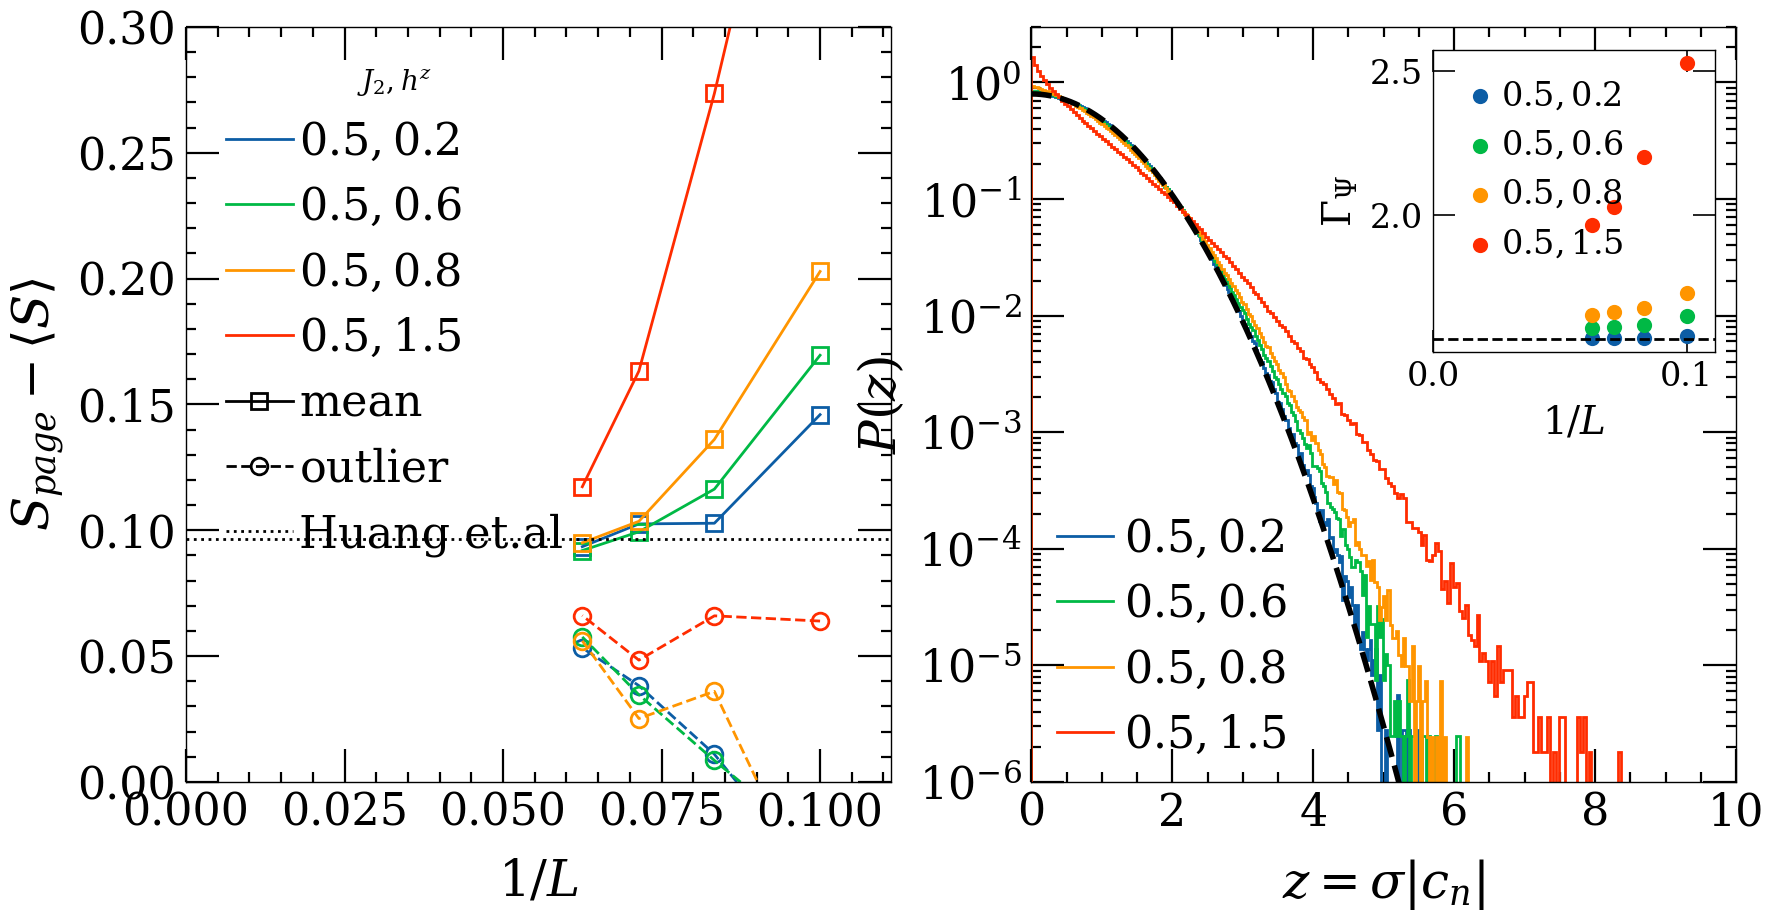

In [28]:
print("Let's start")
fig = plt.figure(figsize=(10,5), dpi = 200)

gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axes = [None, None]
axes[0] = fig.add_subplot(gs[0])
axes[1] = fig.add_subplot(gs[1])

plot_abs = False

width = 0.4
height = 0.4
ax_inset = hfun.add_subplot_axes(axes[1], [0.97 - width, 0.97 - height, width, height])
print("Let's start")
axis = axes[0]
colors = ['blue', 'black', 'green', 'red']
def lablab(val):
    return r"$J_2=%.1f$"%val if use_J_change else r"$h^z=%.1f$"%val
f=0.5

#for ii, xx in enumerate(x_points):
my_pars = [[0.5, hz] for hz in hz_points]
for [J2, hz] in my_pars:
    ii = pars.index([J2, hz])
    print(f'J2={J2}, hz={hz}')
    S = S_obc_list[ii]
    S_max = S_max_obc_list[ii]
    dimsa =  dims_obc_list[ii]
    edge = edges_onc[ii]
    hist = hist_obc[ii]
    S_total = []
    for i, L in enumerate(sizes_obc):
        S_tot_tmp = 0
        dims = 0
        for jj, Ss in enumerate(S[i]): 
            S_tot_tmp += Ss * dimsa[i][jj]
            dims += dimsa[i][jj]
        
        S_total.append(S_tot_tmp / dims if dims > 0 else np.nan)
        
    p = axis.plot(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_total, markerfacecolor='None', marker='s', markersize=6)
    axis.plot(1. / sizes_obc, page_result(f * sizes_obc, (1-f)*sizes_obc) - S_max, color = p[0].get_color(), markerfacecolor='None', marker='o', linestyle='--', markersize=6)
    axis.plot(np.nan, np.nan, color = p[0].get_color(), label=r"$%.1f,%.1f$"%(J2, hz))

    axes[1].stairs(hist[-2], edge[-2], label=r"$%.1f,%.1f$"%(J2, hz))
    for jj in range(len(edge)):
        if jj == 0:     ax_inset.scatter(1/sizes_obc[jj], gauss_obc[ii][jj], color=p[0].get_color(), s=20, label=r"$%.1f,%.1f$"%(J2, hz))
        else:           ax_inset.scatter(1/sizes_obc[jj], gauss_obc[ii][jj], color=p[0].get_color(), s=20)

#edge = edges[-1]
#hist = histograms[-1]
#for i in range(len(edge)):  axes[1].stairs(hist[i], edge[i], label=r"$L=%d$"%(sizes[i]))

axis.plot(np.nan, np.nan, color = 'black', markerfacecolor='None', marker='s', markersize=6, label='mean')
axis.plot(np.nan, np.nan, color = 'black', markerfacecolor='None', linestyle ='--', marker='o', markersize=6, label='outlier')
axis.axhline(y = 0.096574, linestyle=':', color='black', label='Huang et.al')


new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scales(xscale='linear', yscale='linear')
settings = getattr(new_set_class, 'settings')

hfun.set_plot_elements(axis = axis, ylabel = "S_{page}-\\langle S\\rangle", xlabel = "1/L", settings=settings, 
                        font_size=16, set_legend=False, xlim=(0, 1/9), ylim=(0.0, 0.3))
axis.legend(fontsize=16, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.5, title=r"$J_2, h^z$")

ylab = "P(z)"
xlab = "z=\\sigma|c_n|"
hfun.set_plot_elements(axis = axes[1], ylabel = ylab, xlabel = xlab, settings=user_settings, 
                            font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
axes[1].legend(loc = 'lower left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, -0.02))




val = np.pi / 2
valname = r"$\pi/2$"

ax_inset.axhline(y=val, ls='--', color='black')

hfun.set_plot_elements(axis = ax_inset, ylabel = "\\Gamma_\\Psi", xlabel = "1 / L", settings=settings, 
                        font_size=12, set_legend=False, xlim=(0.0, 1/9), ylim=(None, None))
ax_inset.legend(fontsize=12, loc='upper left', ncol=1, handletextpad=0.15, handlelength = 1.)


#yticks = [val, 1.7, 1.9, 2.1]
#tick_labels = ["%.1f"%ytic if ytic != val else valname for ytic in yticks]
#ax_inset.set_yticks(yticks)
#ax_inset.set_yticklabels(tick_labels)
#ax_inset.set_ylim(1.5, 2.2)
#
#xticks = [0, 0.5, 1.0, 1.5, 2.0]
#tick_labels = ["%.1f"%xtic if xtic not in [0, 1, 2] else "%d"%xtic for xtic in xticks]
#ax_inset.set_xticks(xticks)
#ax_inset.set_xticklabels(tick_labels)
#
ax_inset.xaxis.set_minor_locator(plt.NullLocator())
ax_inset.yaxis.set_minor_locator(plt.NullLocator())


axes[1].set_xscale('linear')
axes[1].set_yscale('log')
aa = np.linspace(-100.0, 100, 20000)
mu=0.0
sigma=1.
axes[1].set_ylim(1e-6, 3.0)
axes[1].set_xlim(0, 10)

axes[1].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black', linewidth=2)
    

# RMT

In [51]:
import tenpy.linalg.random_matrix as rmt

In [57]:

def generate_cpx_goe(dim):
    A = rmt.GOE( (dim, dim) )
    B = rmt.GOE( (dim, dim) )
    B = np.zeros( (dim, dim) )
    
    C = (A + np.transpose(B) * 1j)
    C = (C + np.transpose(C)) / 2.
    E, V = np.linalg.eigh(C)
    return E, V

#---------------------------------------------
def get_midspectrum_states(num_realis, dim = 1000):
    states = []
    r = 0
    for i in range(num_realis):

        E, V = generate_cpx_goe(dim)
        dim = E.size
        E_av = np.mean(E)
        idx = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
        gaps = np.diff(E)
        r_tmp = 0
        counter = 0
        mu = int(0.5 * (dim // 2))
        for i in range(int(idx - mu), int(idx + mu)):
            r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
            counter += 1

        r += r_tmp / counter
        print(idx, E_av, r_tmp / counter)
        Vv = V[idx - 100 : idx + 100]
        states += list(Vv.flatten())
    print(r / num_realis)
    return states


In [59]:
states = get_midspectrum_states(num_realis=100, dim=500)

251 0.0234129670131324 0.5378992491889033
249 -0.011361324887103365 0.48159760857265344
248 -0.03967153753848834 0.5289747267998429
250 0.01759515341473434 0.5507473376885198
249 -0.04690616881389815 0.5026920282443629
250 0.0045815453151299155 0.5123587279090913
250 0.00864322262999849 0.5368257078907743
249 0.026438250388496273 0.5370068427411508
248 0.039853215765013376 0.5343876299375504
249 -0.06593734824509648 0.5268562562373259
249 0.008900527522511765 0.5249002052511254


KeyboardInterrupt: 